# create_data.py

In [14]:
import torchvision
import os
import errno
import shutil
from pathlib import Path
from PIL import Image

def create_folder(path):
    try:
        os.mkdir(path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass

def del_folder(path):
    try:
        shutil.rmtree(path)
    except OSError as exc:
        pass


CelebA_folder = '/fs/cml-datasets/CelebA-HQ/images-128/' # change this to folder which has CelebA data

############################################# MNIST ###############################################
trainset = torchvision.datasets.MNIST(
            root='/kaggle/working/data', train=True, download=True)
root = '/kaggle/working/root_mnist/'
del_folder(root)
create_folder(root)

for i in range(10):
    lable_root = root + str(i) + '/'
    create_folder(lable_root)

for idx in range(len(trainset)):
    img, label = trainset[idx]
    print(idx)
    img.save(root + str(label) + '/' + str(idx) + '.png')


trainset = torchvision.datasets.MNIST(
            root='/kaggle/working/data', train=False, download=True)
root = '/kaggle/working/root_mnist_test/'
del_folder(root)
create_folder(root)

for i in range(10):
    lable_root = root + str(i) + '/'
    create_folder(lable_root)

for idx in range(len(trainset)):
    img, label = trainset[idx]
    print(idx)
    img.save(root + str(label) + '/' + str(idx) + '.png')


############################################# Cifar10 ###############################################
trainset = torchvision.datasets.CIFAR10(
            root='/kaggle/working/data', train=True, download=True)
root = '/kaggle/working/root_cifar10/'
del_folder(root)
create_folder(root)

for i in range(10):
    lable_root = root + str(i) + '/'
    create_folder(lable_root)

for idx in range(len(trainset)):
    img, label = trainset[idx]
    print(idx)
    img.save(root + str(label) + '/' + str(idx) + '.png')


trainset = torchvision.datasets.CIFAR10(
            root='/kaggle/working/data', train=False, download=True)
root = '/kaggle/working/root_cifar10_test/'
del_folder(root)
create_folder(root)

for i in range(10):
    lable_root = root + str(i) + '/'
    create_folder(lable_root)

for idx in range(len(trainset)):
    img, label = trainset[idx]
    print(idx)
    img.save(root + str(label) + '/' + str(idx) + '.png')


############################################# CelebA ###############################################
root_train = '/kaggle/working/root_celebA_128_train_new/'
root_test = '/kaggle/working/root_celebA_128_test_new/'
del_folder(root_train)
create_folder(root_train)

del_folder(root_test)
create_folder(root_test)

exts = ['jpg', 'jpeg', 'png']
folder = CelebA_folder
paths = [p for ext in exts for p in Path(f'{folder}').glob(f'**/*.{ext}')]

for idx in range(len(paths)):
    img = Image.open(paths[idx])
    print(idx)
    if idx < 0.9*len(paths):
        img.save(root_train + str(idx) + '.png')
    else:
        img.save(root_test + str(idx) + '.png')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Model2.py

In [15]:
import math
import torch
import torch.nn as nn


def get_timestep_embedding(timesteps, embedding_dim):
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models:
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0,1,0,0))
    return emb


def nonlinearity(x):
    # swish
    return x*torch.sigmoid(x)


def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)


class Upsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(x, scale_factor=2.0, mode="nearest")
        if self.with_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0,1,0,1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        self.temb_proj = torch.nn.Linear(temb_channels,
                                         out_channels)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)

    def forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        h = h + self.temb_proj(nonlinearity(temb))[:,:,None,None]

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h


class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)


    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b,c,h,w = q.shape
        q = q.reshape(b,c,h*w)
        q = q.permute(0,2,1)   # b,hw,c
        k = k.reshape(b,c,h*w) # b,c,hw
        w_ = torch.bmm(q,k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b,c,h*w)
        w_ = w_.permute(0,2,1)   # b,hw,hw (first hw of k, second of q)
        h_ = torch.bmm(v,w_)     # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = h_.reshape(b,c,h,w)

        h_ = self.proj_out(h_)

        return x+h_


class Model(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution):
        super().__init__()
        self.ch = ch
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # timestep embedding
        self.temb = nn.Module()
        self.temb.dense = nn.ModuleList([
            torch.nn.Linear(self.ch,
                            self.temb_ch),
            torch.nn.Linear(self.temb_ch,
                            self.temb_ch),
        ])

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+ch_mult
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level]
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up) # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)


    def forward(self, x, t):
        assert x.shape[2] == x.shape[3] == self.resolution

        # timestep embedding
        temb = get_timestep_embedding(t, self.ch)
        temb = self.temb.dense[0](temb)
        temb = nonlinearity(temb)
        temb = self.temb.dense[1](temb)

        # print(t)
        # print(temb)

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](
                    torch.cat([h, hs.pop()], dim=1), temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

# deblurring_diffusion_pytorch.py

In [16]:
!pip install comet_ml
!pip install torchgeometry
!pip install pytorch_msssim

# Loss

In [17]:
import torch
import torch.nn.functional as F

def contrastive_loss(z_i, z_j, temperature=0.5):
    """
    Contrastive loss (NT-Xent loss) for a pair of embeddings z_i and z_j.
    Args:
        z_i: Embedding tensor for the first set of samples (shape: [batch_size, channels, height, width]).
        z_j: Embedding tensor for the second set of samples (shape: [batch_size, channels, height, width]).
        temperature: Temperature scaling factor.
    Returns:
        loss: Computed contrastive loss.
    """
    # Flatten spatial dimensions into feature dimensions
    z_i = z_i.view(z_i.size(0), -1)  # Shape: [batch_size, feature_dim]
    z_j = z_j.view(z_j.size(0), -1)  # Shape: [batch_size, feature_dim]

    # Concatenate positive pairs
    z = torch.cat([z_i, z_j], dim=0)  # Shape: [2 * batch_size, feature_dim]
    z = F.normalize(z, dim=1)         # Normalize embeddings to unit norm

    # Compute similarity matrix (dot product)
    similarity_matrix = torch.mm(z, z.T)  # Shape: [2*batch_size, 2*batch_size]

    # Create mask for self-similarities
    batch_size = z_i.size(0)
    mask = torch.eye(2 * batch_size, device=z.device).bool()

    # Apply the mask to remove self-similarities
    similarity_matrix = similarity_matrix.masked_fill(mask, float('-inf'))

    # Apply temperature scaling
    logits = similarity_matrix / temperature

    # Create ground-truth labels
    labels = torch.cat(
        [torch.arange(batch_size, device=z.device) + batch_size,
         torch.arange(batch_size, device=z.device)]
    )  # Shape: [2*batch_size]

    # Compute contrastive loss
    loss = F.cross_entropy(logits, labels)
    return loss


# Augmentation

In [18]:
from torchvision import transforms

def get_augmentations(image_size):
    """
    Augmentations for self-supervised learning, ensuring compatibility with tensors.
    """
    return transforms.Compose([
        transforms.Lambda(lambda x: transforms.ToPILImage()(x)),  # Convert tensor to PIL Image
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

# diffusion_deblurring_pytorch.py

In [19]:
from comet_ml import Experiment
import math
import copy
import torch
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial

from torch.utils import data
from pathlib import Path
from torch.optim import Adam
from torchvision import transforms, utils

import numpy as np
from tqdm import tqdm
from einops import rearrange

import torchgeometry as tgm
import glob
import os
from PIL import Image


try:
    from apex import amp

    APEX_AVAILABLE = True
except:
    APEX_AVAILABLE = False

# helpers functions


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def cycle(dl):
    while True:
        for data in dl:
            yield data


def cycle_cat(dl):
    while True:
        for data in dl:
            yield data[0]


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


def loss_backwards(fp16, loss, optimizer, **kwargs):
    if fp16:
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward(**kwargs)
    else:
        loss.backward(**kwargs)


# small helper modules


class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(
            current_model.parameters(), ma_model.parameters()
        ):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)


def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (var + self.eps).sqrt() * self.g + self.b


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


# building block modules


class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            LayerNorm(dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = (
            nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
        )

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp):
            assert exists(time_emb), "time emb must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads),
            qkv,
        )
        q = q * self.scale

        k = k.softmax(dim=-1)
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(
            out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w
        )
        return self.to_out(out)


# model


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        residual=False,
    ):
        super(e_dim = dim
            self.time_mlp = nn.Sequential(
                SinusoidalPosEmb(dim),
                nn.Linear(dim, dim * 4),
                nn.GELU(),
                nn.Linear(dim * 4, dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        ConvNextBlock(
                            dim_in,
                            dim_out,
                            time_emb_dim=time_dim,
                            norm=ind != 0,
                        ),
                        ConvNextBlock(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = ConvNextBlock(
            mid_dim, mid_dim, time_emb_dim=time_dim
        )
        self.mid_attn = Residual(PreNorm(mid_dim, LinearAttention(mid_dim)))
        self.mid_block2 = ConvNextBlock(
            mid_dim, mid_dim, time_emb_dim=time_dim
        )

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        ConvNextBlock(
                            dim_out * 2, dim_in, time_emb_dim=time_dim
                        ),
                        ConvNextBlock(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            ConvNextBlock(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
          orig_x = x
          t = self.time_mlp(time) if exists(self.time_mlp) else None

          h = []
          embeddings = []  # Store intermediate embeddings

          # Downsampling path
          for convnext, convnext2, attn, downsample in self.downs:
              x = convnext(x, t)
              x = convnext2(x, t)
              x = attn(x)
              h.append(x)
              embeddings.append(x)  # Store embedding after each downsample
              x = downsample(x)

          # Middle block
          x = self.mid_block1(x, t)
          x = self.mid_attn(x)
          x = self.mid_block2(x, t)

          embeddings.append(x)  # Store embedding from middle block

          # Upsampling path
          for convnext, convnext2, attn, upsample in self.ups:
              x = torch.cat((x, h.pop()), dim=1)
              x = convnext(x, t)
              x = convnext2(x, t)
              x = attn(x)
              x = upsample(x)

          # Resize all embeddings to the original input size
          target_size = orig_x.shape[2:]  # Original spatial dimensions (H, W)
          resized_embeddings = [
              F.interpolate(embed, size=target_size, mode="bilinear", align_corners=False)
              for embed in embeddings
          ]

          # Concatenate resized embeddings along the channel dimension
          combined_embeddings = torch.cat(resized_embeddings, dim=1)

          if self.residual:
              return self.final_conv(x) + orig_x, combined_embeddings

          return self.final_conv(x), combined_embeddings).__init__()
        self.channels = channels
        self.residual = residual
        print("Is Time embed used ? ", with_time_emb)

        dims = [channels, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if with_time_emb:
            time_dim = dim
            self.time_mlp = nn.Sequential(
                SinusoidalPosEmb(dim),
                nn.Linear(dim, dim * 4),
                nn.GELU(),
                nn.Linear(dim * 4, dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        ConvNextBlock(
                            dim_in,
                            dim_out,
                            time_emb_dim=time_dim,
                            norm=ind != 0,
                        ),
                        ConvNextBlock(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = ConvNextBlock(
            mid_dim, mid_dim, time_emb_dim=time_dim
        )
        self.mid_attn = Residual(PreNorm(mid_dim, LinearAttention(mid_dim)))
        self.mid_block2 = ConvNextBlock(
            mid_dim, mid_dim, time_emb_dim=time_dim
        )

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        ConvNextBlock(
                            dim_out * 2, dim_in, time_emb_dim=time_dim
                        ),
                        ConvNextBlock(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            ConvNextBlock(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
          orig_x = x
          t = self.time_mlp(time) if exists(self.time_mlp) else None

          h = []
          embeddings = []  # Store intermediate embeddings

          # Downsampling path
          for convnext, convnext2, attn, downsample in self.downs:
              x = convnext(x, t)
              x = convnext2(x, t)
              x = attn(x)
              h.append(x)
              embeddings.append(x)  # Store embedding after each downsample
              x = downsample(x)

          # Middle block
          x = self.mid_block1(x, t)
          x = self.mid_attn(x)
          x = self.mid_block2(x, t)

          embeddings.append(x)  # Store embedding from middle block

          # Upsampling path
          for convnext, convnext2, attn, upsample in self.ups:
              x = torch.cat((x, h.pop()), dim=1)
              x = convnext(x, t)
              x = convnext2(x, t)
              x = attn(x)
              x = upsample(x)

          # Resize all embeddings to the original input size
          target_size = orig_x.shape[2:]  # Original spatial dimensions (H, W)
          resized_embeddings = [
              F.interpolate(embed, size=target_size, mode="bilinear", align_corners=False)
              for embed in embeddings
          ]

          # Concatenate resized embeddings along the channel dimension
          combined_embeddings = torch.cat(resized_embeddings, dim=1)

          if self.residual:
              return self.final_conv(x) + orig_x, combined_embeddings

          return self.final_conv(x), combined_embeddings




# gaussian diffusion trainer class


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(
        shape[0], *((1,) * (len(shape) - 1))
    )
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = np.linspace(0, steps, steps)
    alphas_cumprod = np.cos(((x / steps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, a_min=0, a_max=0.999)


import torch
import torchvision


class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        denoise_fn,
        *,
        image_size,
        device_of_kernel,
        channels=3,
        timesteps=1000,
        loss_type="l1",
        kernel_std=0.1,
        kernel_size=3,
        blur_routine="Incremental",
        train_routine="Final",
        sampling_routine="default",
        discrete=False,
    ):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        self.denoise_fn = denoise_fn
        self.device_of_kernel = device_of_kernel

        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type
        self.kernel_std = kernel_std
        self.kernel_size = kernel_size
        self.blur_routine = blur_routine

        to_torch = partial(torch.tensor, dtype=torch.float32)
        self.gaussian_kernels = nn.ModuleList(self.get_kernels())
        self.train_routine = train_routine
        self.sampling_routine = sampling_routine
        self.discrete = discrete


    def blur(self, dims, std):
        return tgm.image.get_gaussian_kernel2d(dims, std)

    def get_conv(self, dims, std, mode="circular"):
        kernel = self.blur(dims, std)
        conv = nn.Conv2d(
            in_channels=self.channels,
            out_channels=self.channels,
            kernel_size=dims,
            padding=int((dims[0] - 1) / 2),
            padding_mode=mode,
            bias=False,
            groups=self.channels,
        )
        with torch.no_grad():
            kernel = torch.unsqueeze(kernel, 0)
            kernel = torch.unsqueeze(kernel, 0)
            kernel = kernel.repeat(self.channels, 1, 1, 1)
            conv.weight = nn.Parameter(kernel)

        return conv

    def get_kernels(self):
        kernels = []
        for i in range(self.num_timesteps):
            if self.blur_routine == "Incremental":
                kernels.append(
                    self.get_conv(
                        (self.kernel_size, self.kernel_size),
                        (self.kernel_std * (i + 1), self.kernel_std * (i + 1)),
                    )
                )
            elif self.blur_routine == "Constant":
                kernels.append(
                    self.get_conv(
                        (self.kernel_size, self.kernel_size),
                        (self.kernel_std, self.kernel_std),
                    )
                )
            elif self.blur_routine == "Constant_reflect":
                kernels.append(
                    self.get_conv(
                        (self.kernel_size, self.kernel_size),
                        (self.kernel_std, self.kernel_std),
                        mode="reflect",
                    )
                )
            elif self.blur_routine == "Exponential_reflect":
                ks = self.kernel_size
                kstd = np.exp(self.kernel_std * i)
                kernels.append(
                    self.get_conv((ks, ks), (kstd, kstd), mode="reflect")
                )
            elif self.blur_routine == "Exponential":
                ks = self.kernel_size
                kstd = np.exp(self.kernel_std * i)
                kernels.append(self.get_conv((ks, ks), (kstd, kstd)))
            elif self.blur_routine == "Individual_Incremental":
                ks = 2 * i + 1
                kstd = 2 * ks
                kernels.append(self.get_conv((ks, ks), (kstd, kstd)))
            elif self.blur_routine == "Special_6_routine":
                ks = 11
                kstd = i / 100 + 0.35
                kernels.append(
                    self.get_conv((ks, ks), (kstd, kstd), mode="reflect")
                )

        return kernels

    @torch.no_grad()
    def sample(self, batch_size=16, img=None, t=None):

        self.denoise_fn.eval()

        if t == None:
            t = self.num_timesteps

        if self.blur_routine == "Individual_Incremental":
            img = self.gaussian_kernels[t - 1](img)

        else:
            for i in range(t):
                with torch.no_grad():
                    img = self.gaussian_kernels[i](img)

        orig_mean = torch.mean(img, [2, 3], keepdim=True)
        print(orig_mean.squeeze()[0])

        temp = img
        if self.discrete:
            img = torch.mean(img, [2, 3], keepdim=True)
            img = img.expand(
                temp.shape[0], temp.shape[1], temp.shape[2], temp.shape[3]
            )

        # 3(2), 2(1), 1(0)
        xt = img
        direct_recons = None
        while t:
            step = torch.full((batch_size,), t - 1, dtype=torch.long).cuda()
            x, _ = self.denoise_fn(img, step)

            if self.train_routine == "Final":
                if direct_recons == None:
                    direct_recons = x

                if self.sampling_routine == "default":
                    if self.blur_routine == "Individual_Incremental":
                        x = self.gaussian_kernels[t - 2](x)
                    else:
                        for i in range(t - 1):
                            with torch.no_grad():
                                x = self.gaussian_kernels[i](x)

                elif self.sampling_routine == "x0_step_down":
                    x_times = x
                    for i in range(t):
                        with torch.no_grad():
                            x_times = self.gaussian_kernels[i](x_times)
                            if self.discrete:
                                if i == (self.num_timesteps - 1):
                                    x_times = torch.mean(
                                        x_times, [2, 3], keepdim=True
                                    )
                                    x_times = x_times.expand(
                                        temp.shape[0],
                                        temp.shape[1],
                                        temp.shape[2],
                                        temp.shape[3],
                                    )

                    x_times_sub_1 = x
                    for i in range(t - 1):
                        with torch.no_grad():
                            x_times_sub_1 = self.gaussian_kernels[i](
                                x_times_sub_1
                            )

                    x = img - x_times + x_times_sub_1
            img = x
            t = t - 1
        self.denoise_fn.train()
        return xt, direct_recons, img

    @torch.no_grad()
    def gen_sample_2(self, batch_size=16, img=None, t=None, noise_level=0):

        self.denoise_fn.eval()

        if t == None:
            t = self.num_timesteps

        if self.blur_routine == "Individual_Incremental":
            img = self.gaussian_kernels[t - 1](img)

        else:
            for i in range(t):
                with torch.no_grad():
                    img = self.gaussian_kernels[i](img)

        orig_mean = torch.mean(img, [2, 3], keepdim=True)
        print(orig_mean.squeeze()[0])

        temp = img
        if self.discrete:
            img = torch.mean(img, [2, 3], keepdim=True)
            img = img.expand(
                temp.shape[0], temp.shape[1], temp.shape[2], temp.shape[3]
            )

        noise = torch.randn_like(img) * noise_level
        img = img + noise

        # 3(2), 2(1), 1(0)
        xt = img
        direct_recons = None
        while t:
            step = torch.full((batch_size,), t - 1, dtype=torch.long).cuda()
            x, _ = self.denoise_fn(img, step)

            if self.train_routine == "Final":
                if direct_recons == None:
                    direct_recons = x

                if self.sampling_routine == "default":
                    if self.blur_routine == "Individual_Incremental":
                        x = self.gaussian_kernels[t - 2](x)
                    else:
                        for i in range(t - 1):
                            with torch.no_grad():
                                x = self.gaussian_kernels[i](x)

                elif self.sampling_routine == "x0_step_down":
                    x_times = x
                    for i in range(t):
                        with torch.no_grad():
                            x_times = self.gaussian_kernels[i](x_times)
                            if self.discrete:
                                if i == (self.num_timesteps - 1):
                                    x_times = torch.mean(
                                        x_times, [2, 3], keepdim=True
                                    )
                                    x_times = x_times.expand(
                                        temp.shape[0],
                                        temp.shape[1],
                                        temp.shape[2],
                                        temp.shape[3],
                                    )

                    x_times_sub_1 = x
                    for i in range(t - 1):
                        with torch.no_grad():
                            x_times_sub_1 = self.gaussian_kernels[i](
                                x_times_sub_1
                            )

                    x = img - x_times + x_times_sub_1
            img = x
            t = t - 1

        # img = img - noise

        return xt, direct_recons, img

    @torch.no_grad()
    def gen_sample(self, batch_size=16, img=None, t=None, noise_level=0):

        self.denoise_fn.eval()

        if t == None:
            t = self.num_timesteps

        if self.blur_routine == "Individual_Incremental":
            img = self.gaussian_kernels[t - 1](img)

        else:
            for i in range(t):
                with torch.no_grad():
                    img = self.gaussian_kernels[i](img)

        orig_mean = torch.mean(img, [2, 3], keepdim=True)
        print(orig_mean.squeeze()[0])

        temp = img
        if self.discrete:
            img = torch.mean(img, [2, 3], keepdim=True)
            img = img.expand(
                temp.shape[0], temp.shape[1], temp.shape[2], temp.shape[3]
            )

        noise = torch.randn_like(img) * noise_level
        img = img + noise

        # 3(2), 2(1), 1(0)
        xt = img
        direct_recons = None
        while t:
            step = torch.full((batch_size,), t - 1, dtype=torch.long).cuda()
            x, _ = self.denoise_fn(img, step)

            if self.train_routine == "Final":
                if direct_recons == None:
                    direct_recons = x

                if self.sampling_routine == "default":
                    if self.blur_routine == "Individual_Incremental":
                        x = self.gaussian_kernels[t - 2](x)
                    else:
                        for i in range(t - 1):
                            with torch.no_grad():
                                x = self.gaussian_kernels[i](x)

                elif self.sampling_routine == "x0_step_down":
                    x_times = x
                    for i in range(t):
                        with torch.no_grad():
                            x_times = self.gaussian_kernels[i](x_times)
                            if self.discrete:
                                if i == (self.num_timesteps - 1):
                                    x_times = torch.mean(
                                        x_times, [2, 3], keepdim=True
                                    )
                                    x_times = x_times.expand(
                                        temp.shape[0],
                                        temp.shape[1],
                                        temp.shape[2],
                                        temp.shape[3],
                                    )

                    x_times_sub_1 = x
                    for i in range(t - 1):
                        with torch.no_grad():
                            x_times_sub_1 = self.gaussian_kernels[i](
                                x_times_sub_1
                            )

                    x = img - x_times + x_times_sub_1
            img = x
            t = t - 1

        # img = img - noise

        return xt, direct_recons, img

    @torch.no_grad()
    def opt(self, img, t=None):
        if t is None:
            t = self.num_timesteps

        if self.blur_routine == "Individual_Incremental":
            img = self.gaussian_kernels[t - 1](img)
        else:
            for i in range(t):
                with torch.no_grad():
                    img = self.gaussian_kernels[i](img)

        return img

    @torch.no_grad()
    def all_sample(
        self, batch_size=16, img=None, t=None, times=None, eval=True
    ):

        if eval:
            self.denoise_fn.eval()

        if t == None:
            t = self.num_timesteps
        if times == None:
            times = t

        if self.blur_routine == "Individual_Incremental":
            img = self.gaussian_kernels[t - 1](img)
        else:
            for i in range(t):
                with torch.no_grad():
                    img = self.gaussian_kernels[i](img)

        X_0s = []
        X_ts = []
        temp = img
        if self.discrete:
            img = torch.mean(img, [2, 3], keepdim=True)
            img = img.expand(
                temp.shape[0], temp.shape[1], temp.shape[2], temp.shape[3]
            )
            noise = torch.randn_like(img) * 0.001
            img = img + noise

        # 3(2), 2(1), 1(0)
        while times:
            step = torch.full(
                (batch_size,), times - 1, dtype=torch.long
            ).cuda()
            x, _ = self.denoise_fn(img, step)
            X_0s.append(x)
            X_ts.append(img)

            if self.train_routine == "Final":
                if self.sampling_routine == "default":
                    if self.blur_routine == "Individual_Incremental":
                        if times - 2 >= 0:
                            x = self.gaussian_kernels[times - 2](img)
                    else:
                        x_times_sub_1 = x
                        for i in range(times - 1):
                            with torch.no_grad():
                                x_times_sub_1 = self.gaussian_kernels[i](
                                    x_times_sub_1
                                )

                        x = x_times_sub_1

                elif self.sampling_routine == "x0_step_down":
                    if self.blur_routine == "Individual_Incremental":
                        if times - 2 >= 0:
                            x = self.gaussian_kernels[times - 2](img)
                    else:
                        x_times = x
                        for i in range(times):
                            with torch.no_grad():
                                x_times = self.gaussian_kernels[i](x_times)
                                if self.discrete:
                                    if i == (self.num_timesteps - 1):
                                        x_times = torch.mean(
                                            x_times, [2, 3], keepdim=True
                                        )
                                        x_times = x_times.expand(
                                            temp.shape[0],
                                            temp.shape[1],
                                            temp.shape[2],
                                            temp.shape[3],
                                        )

                        x_times_sub_1 = x
                        for i in range(times - 1):
                            with torch.no_grad():
                                x_times_sub_1 = self.gaussian_kernels[i](
                                    x_times_sub_1
                                )

                        x = img - x_times + x_times_sub_1
                        # x = x - (noise/self.num_timesteps)

            img = x
            times = times - 1

        if self.discrete:
            img = img - noise
        X_0s.append(img)

        self.denoise_fn.train()
        return X_0s, X_ts

    @torch.no_grad()
    def forward_and_backward(
        self,
        batch_size=16,
        img=None,
        noise_level=0,
        t=None,
        times=None,
        eval=True,
    ):

        if eval:
            self.denoise_fn.eval()

        if t == None:
            t = self.num_timesteps
        if times == None:
            times = t

        Forward = []
        Forward.append(img)

        if self.blur_routine == "Individual_Incremental":
            img = self.gaussian_kernels[t - 1](img)
        else:
            for i in range(t):
                with torch.no_grad():
                    img = self.gaussian_kernels[i](img)
                    Forward.append(img)

        Backward = []
        temp = img
        if self.discrete:
            img = torch.mean(img, [2, 3], keepdim=True)
            img = img.expand(
                temp.shape[0], temp.shape[1], temp.shape[2], temp.shape[3]
            )
            noise = torch.randn_like(img) * noise_level
            img = img + noise

        # 3(2), 2(1), 1(0)
        while times:
            print(times)
            step = torch.full(
                (batch_size,), times - 1, dtype=torch.long
            ).cuda()
            x = self.denoise_fn(img, step)
            Backward.append(img)

            if self.train_routine == "Final":
                if self.sampling_routine == "default":
                    if self.blur_routine == "Individual_Incremental":
                        if times - 2 >= 0:
                            x = self.gaussian_kernels[times - 2](img)
                    else:
                        x_times_sub_1 = x
                        for i in range(times - 1):
                            with torch.no_grad():
                                x_times_sub_1 = self.gaussian_kernels[i](
                                    x_times_sub_1
                                )

                        x = x_times_sub_1

                elif self.sampling_routine == "x0_step_down":
                    if self.blur_routine == "Individual_Incremental":
                        if times - 2 >= 0:
                            x = self.gaussian_kernels[times - 2](img)
                    else:
                        x_times = x
                        for i in range(times):
                            with torch.no_grad():
                                x_times = self.gaussian_kernels[i](x_times)
                                if self.discrete:
                                    if i == (self.num_timesteps - 1):
                                        x_times = torch.mean(
                                            x_times, [2, 3], keepdim=True
                                        )
                                        x_times = x_times.expand(
                                            temp.shape[0],
                                            temp.shape[1],
                                            temp.shape[2],
                                            temp.shape[3],
                                        )

                        x_times_sub_1 = x
                        for i in range(times - 1):
                            with torch.no_grad():
                                x_times_sub_1 = self.gaussian_kernels[i](
                                    x_times_sub_1
                                )

                        x = img - x_times + x_times_sub_1
                        # x = x - (noise/self.num_timesteps)

            img = x
            times = times - 1

        return Forward, Backward, img

    @torch.no_grad()
    def forward_and_backward_2(
        self, batch_size=16, img=None, noise_level=0, eval=True
    ):

        if eval:
            self.denoise_fn.eval()

        times = self.num_timesteps

        Forward = []
        orig_img = img
        Forward.append(img)

        for i in range(times):
            with torch.no_grad():
                img = self.gaussian_kernels[i](img)
                Forward.append(img)

        Backward_1 = []
        temp = img
        if self.discrete:
            img = torch.mean(img, [2, 3], keepdim=True)
            img = img.expand(
                temp.shape[0], temp.shape[1], temp.shape[2], temp.shape[3]
            )
            noise = torch.randn_like(img) * noise_level
            img = img + noise
        last_img = img

        while times:
            print(times)
            step = torch.full(
                (batch_size,), times - 1, dtype=torch.long
            ).cuda()
            x, _ = self.denoise_fn(img, step)
            Backward_1.append(img)

            x_times = x
            for i in range(times):
                with torch.no_grad():
                    x_times = self.gaussian_kernels[i](x_times)
                    if self.discrete:
                        if i == (self.num_timesteps - 1):
                            x_times = torch.mean(x_times, [2, 3], keepdim=True)
                            x_times = x_times.expand(
                                temp.shape[0],
                                temp.shape[1],
                                temp.shape[2],
                                temp.shape[3],
                            )

            x_times_sub_1 = x
            for i in range(times - 1):
                with torch.no_grad():
                    x_times_sub_1 = self.gaussian_kernels[i](x_times_sub_1)

            x = img - img + x_times_sub_1

            img = x
            times = times - 1

        img_1 = img

        times = self.num_timesteps
        img = last_img
        Backward_2 = []

        while times:
            print(times)
            step = torch.full(
                (batch_size,), times - 1, dtype=torch.long
            ).cuda()
            x, _ = self.denoise_fn(img, step)
            Backward_2.append(img)

            x_times = x
            for i in range(times):
                with torch.no_grad():
                    x_times = self.gaussian_kernels[i](x_times)
                    if self.discrete:
                        if i == (self.num_timesteps - 1):
                            x_times = torch.mean(x_times, [2, 3], keepdim=True)
                            x_times = x_times.expand(
                                temp.shape[0],
                                temp.shape[1],
                                temp.shape[2],
                                temp.shape[3],
                            )

            x_times_sub_1 = x
            for i in range(times - 1):
                with torch.no_grad():
                    x_times_sub_1 = self.gaussian_kernels[i](x_times_sub_1)

            x = img - x_times + x_times_sub_1

            img = x
            times = times - 1

        img_2 = img

        return Forward, Backward_1, Backward_2, img_1, img_2

    @torch.no_grad()
    def sample_from_blur(
        self,
        batch_size=16,
        img=None,
        t=None,
        times=None,
        eval=True,
        start=None,
    ):

        if eval:
            self.denoise_fn.eval()

        if t == None:
            t = self.num_timesteps
        if times == None:
            times = t

        if start == None:
            start = 0

        for i in range(start, t):
            with torch.no_grad():
                img = self.gaussian_kernels[i](img)

        temp = img
        if self.discrete:
            img = torch.mean(img, [2, 3], keepdim=True)
            img = img.expand(
                temp.shape[0], temp.shape[1], temp.shape[2], temp.shape[3]
            )

        # 3(2), 2(1), 1(0)
        xt = img
        direct_recons = None
        while t:
            step = torch.full((batch_size,), t - 1, dtype=torch.long).cuda()
            x, _ = self.denoise_fn(img, step)

            if self.train_routine == "Final":
                if direct_recons == None:
                    direct_recons = x

                if self.sampling_routine == "default":
                    if self.blur_routine == "Individual_Incremental":
                        x = self.gaussian_kernels[t - 2](x)
                    else:
                        for i in range(t - 1):
                            with torch.no_grad():
                                x = self.gaussian_kernels[i](x)

                elif self.sampling_routine == "x0_step_down":
                    x_times = x
                    for i in range(t):
                        with torch.no_grad():
                            x_times = self.gaussian_kernels[i](x_times)
                            if self.discrete:
                                if i == (self.num_timesteps - 1):
                                    x_times = torch.mean(
                                        x_times, [2, 3], keepdim=True
                                    )
                                    x_times = x_times.expand(
                                        temp.shape[0],
                                        temp.shape[1],
                                        temp.shape[2],
                                        temp.shape[3],
                                    )

                    x_times_sub_1 = x
                    for i in range(t - 1):
                        with torch.no_grad():
                            x_times_sub_1 = self.gaussian_kernels[i](
                                x_times_sub_1
                            )

                    x = img - x_times + x_times_sub_1
            img = x
            t = t - 1

        return xt, direct_recons, img

    def q_sample(self, x_start, t):
        # So at present we will for each batch blur it till the max in t.
        # And save it. And then use t to pull what I need. It is nothing but series of convolutions anyway.
        # Remember to do convs without torch.grad
        max_iters = torch.max(t)
        all_blurs = []
        x = x_start
        for i in range(max_iters + 1):
            with torch.no_grad():
                x = self.gaussian_kernels[i](x)
                if self.discrete:
                    if i == (self.num_timesteps - 1):
                        x = torch.mean(x, [2, 3], keepdim=True)
                        x = x.expand(
                            x_start.shape[0],
                            x_start.shape[1],
                            x_start.shape[2],
                            x_start.shape[3],
                        )
                all_blurs.append(x)

        all_blurs = torch.stack(all_blurs)

        choose_blur = []
        # step is batch size as well so for the 49th step take the step(batch_size)
        for step in range(t.shape[0]):
            if step != -1:
                choose_blur.append(all_blurs[t[step], step])
            else:
                choose_blur.append(x_start[step])

        choose_blur = torch.stack(choose_blur)
        if self.discrete:
            choose_blur = (choose_blur + 1) * 0.5
            choose_blur = choose_blur * 255
            choose_blur = choose_blur.int().float() / 255
            choose_blur = choose_blur * 2 - 1
        # choose_blur = all_blurs
        return choose_blur

    def p_losses(self, x_start, t):
        b, c, h, w = x_start.shape
        if self.train_routine == "Final":
            x_blur = self.q_sample(x_start=x_start, t=t)
            x_recon, embeddings = self.denoise_fn(x_blur, t)
            if self.loss_type == "l1":
                loss = (x_start - x_recon).abs().mean()
            elif self.loss_type == "l2":
                loss = F.mse_loss(x_start, x_recon)
            else:
                raise NotImplementedError()

        return loss, embeddings

    def forward(self, x, *args, **kwargs):
        (
            b,
            c,
            h,
            w,
            device,
            img_size,
        ) = (
            *x.shape,
            x.device,
            self.image_size,
        )
        assert (
            h == img_size and w == img_size
        ), f"height and width of image must be {img_size}"
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()
        loss, embeddings = self.p_losses(x, t, *args, **kwargs)
        return loss

    def get_embeddings(self, x):
        """
        Extract embeddings from the Unet model (denoise_fn).
        """
        b, c, h, w = x.shape  # Extract batch size, channels, height, and width
        device = x.device  # Get the device of the input tensor
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()  # Random timesteps for each image in the batch
        features, embeddings = self.denoise_fn(x, t)  # Forward pass through Unet
        # embeddings = torch.mean(features, dim=(2, 3))  # Global average pooling
        return embeddings



class Dataset_Aug1(data.Dataset):
    def __init__(self, folder, image_size, exts=["jpg", "jpeg", "png"]):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.paths = [
            p for ext in exts for p in Path(f"{folder}").glob(f"**/*.{ext}")
        ]

        self.transform = transforms.Compose(
            [
                transforms.Resize(
                    (int(image_size * 1.12), int(image_size * 1.12))
                ),
                transforms.RandomCrop(image_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Lambda(lambda t: (t * 2) - 1),
            ]
        )

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)


class Dataset(data.Dataset):
    def __init__(self, folder, image_size, exts=["jpg", "jpeg", "png"]):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.paths = [
            p for ext in exts for p in Path(f"{folder}").glob(f"**/*.{ext}")
        ]

        self.transform = transforms.Compose(
            [
                transforms.Resize(
                    (int(image_size * 1.12), int(image_size * 1.12))
                ),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Lambda(lambda t: (t * 2) - 1),
            ]
        )

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)


# trainer class
import os
import errno


def create_folder(path):
    try:
        os.mkdir(path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass


from collections import OrderedDict


def remove_data_parallel(old_state_dict):
    new_state_dict = OrderedDict()

    for k, v in old_state_dict.items():
        name = k.replace(".module", "")  # remove `module.`
        new_state_dict[name] = v

    return new_state_dict


def adjust_data_parallel(old_state_dict):
    new_state_dict = OrderedDict()

    for k, v in old_state_dict.items():
        name = k.replace(
            "denoise_fn.module", "module.denoise_fn"
        )  # remove `module.`
        new_state_dict[name] = v

    return new_state_dict


class Trainer(object):
    def __init__(
        self,
        diffusion_model,
        folder,
        *,
        ema_decay=0.995,
        image_size=128,
        train_batch_size=32,
        train_lr=2e-5,
        train_num_steps=100000,
        gradient_accumulate_every=2,
        fp16=False,
        step_start_ema=2000,
        update_ema_every=10,
        save_and_sample_every=1000,
        results_folder="/kaggle/working/results",
        load_path=None,
        dataset=None,
        shuffle=True,
    ):
        super().__init__()
        self.model = diffusion_model
        self.ema = EMA(ema_decay)
        self.ema_model = copy.deepcopy(self.model)
        self.update_ema_every = update_ema_every

        self.step_start_ema = step_start_ema
        self.save_and_sample_every = save_and_sample_every

        self.batch_size = train_batch_size
        self.image_size = image_size
        self.gradient_accumulate_every = gradient_accumulate_every
        self.train_num_steps = train_num_steps

        if (
            dataset == "mnist"
            or dataset == "cifar10"
            or dataset == "flower"
            or dataset == "celebA"
            or dataset == "AFHQ"
        ):
            print(dataset, "DA used")
            self.ds = Dataset_Aug1(folder, image_size)
            self.dl = cycle(
                data.DataLoader(
                    self.ds,
                    batch_size=train_batch_size,
                    shuffle=shuffle,
                    pin_memory=True,
                    num_workers=8,
                    drop_last=True,
                )
            )

        elif dataset == "LSUN_train":
            print(dataset, "DA used")
            transform = transforms.Compose(
                [
                    transforms.Resize(
                        (int(image_size * 1.12), int(image_size * 1.12))
                    ),
                    transforms.RandomCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Lambda(lambda t: (t * 2) - 1),
                ]
            )
            self.ds = torchvision.datasets.LSUN(
                root=folder,
                classes=["church_outdoor_train"],
                transform=transform,
            )
            self.dl = cycle_cat(
                data.DataLoader(
                    self.ds,
                    batch_size=train_batch_size,
                    shuffle=shuffle,
                    pin_memory=True,
                    num_workers=16,
                    drop_last=True,
                )
            )

        else:
            print(dataset)
            self.ds = Dataset(folder, image_size)
            self.dl = cycle(
                data.DataLoader(
                    self.ds,
                    batch_size=train_batch_size,
                    shuffle=shuffle,
                    pin_memory=True,
                    num_workers=16,
                    drop_last=True,
                )
            )

        self.opt = Adam(diffusion_model.parameters(), lr=train_lr)
        self.step = 0

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok=True)

        self.fp16 = fp16

        self.reset_parameters()

        if load_path != None:
            self.load(load_path)

    def reset_parameters(self):
        self.ema_model.load_state_dict(self.model.state_dict())

    def step_ema(self):
        if self.step < self.step_start_ema:
            self.reset_parameters()
            return
        self.ema.update_model_average(self.ema_model, self.model)

    def save(self, itrs=None):
        data = {
            "step": self.step,
            "model": self.model.state_dict(),
            "ema": self.ema_model.state_dict(),
        }
        if itrs is None:
            torch.save(data, str(self.results_folder / f"model.pt"))
        else:
            torch.save(data, str(self.results_folder / f"model_{itrs}.pt"))

    def load(self, load_path):
        print("Loading : ", load_path)
        data = torch.load(load_path)

        self.step = data["step"]
        self.model.load_state_dict(data["model"])
        self.ema_model.load_state_dict(data["ema"])

    def add_title(self, path, title):

        import cv2
        import numpy as np

        img1 = cv2.imread(path)

        # --- Here I am creating the border---
        black = [0, 0, 0]  # ---Color of the border---
        constant = cv2.copyMakeBorder(
            img1, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=black
        )
        height = 20
        violet = np.zeros((height, constant.shape[1], 3), np.uint8)
        violet[:] = (255, 0, 180)

        vcat = cv2.vconcat((violet, constant))

        font = cv2.FONT_HERSHEY_SIMPLEX

        cv2.putText(
            vcat,
            str(title),
            (violet.shape[1] // 2, height - 2),
            font,
            0.5,
            (0, 0, 0),
            1,
            0,
        )
        cv2.imwrite(path, vcat)

    def train(self):

        backwards = partial(loss_backwards, self.fp16)

        acc_loss = 0
        while self.step < self.train_num_steps:
            u_loss = 0
            for i in range(self.gradient_accumulate_every):
                data = next(self.dl).cuda()
                loss = torch.mean(self.model(data))  # change for DP
                if self.step % 100 == 0:
                    print(f"{self.step}: {loss.item()}")
                u_loss += loss.item()
                backwards(loss / self.gradient_accumulate_every, self.opt)

            acc_loss = acc_loss + (u_loss / self.gradient_accumulate_every)

            self.opt.step()
            self.opt.zero_grad()

            if self.step % self.update_ema_every == 0:
                self.step_ema()

            if self.step != 0 and self.step % self.save_and_sample_every == 0:
                milestone = self.step // self.save_and_sample_every
                batches = self.batch_size
                og_img = next(self.dl).cuda()
                xt, direct_recons, all_images = self.ema_model.module.sample(
                    batch_size=batches, img=og_img
                )  # change for DP

                og_img = (og_img + 1) * 0.5
                utils.save_image(
                    og_img,
                    str(self.results_folder / f"sample-og-{milestone}.png"),
                    nrow=6,
                )

                all_images = (all_images + 1) * 0.5
                utils.save_image(
                    all_images,
                    str(self.results_folder / f"sample-recon-{milestone}.png"),
                    nrow=6,
                )

                direct_recons = (direct_recons + 1) * 0.5
                utils.save_image(
                    direct_recons,
                    str(
                        self.results_folder
                        / f"sample-direct_recons-{milestone}.png"
                    ),
                    nrow=6,
                )

                xt = (xt + 1) * 0.5
                utils.save_image(
                    xt,
                    str(self.results_folder / f"sample-xt-{milestone}.png"),
                    nrow=6,
                )

                acc_loss = acc_loss / (self.save_and_sample_every + 1)
                print(f"Mean of last {self.step}: {acc_loss}")
                acc_loss = 0

                self.save()
                if self.step % (self.save_and_sample_every * 100) == 0:
                    self.save(self.step)

            self.step += 1

        print("training completed")

    def test_from_data(self, extra_path, s_times=None):
        batches = self.batch_size
        og_img = next(self.dl).cuda()
        X_0s, X_ts = self.ema_model.module.all_sample(
            batch_size=batches, img=og_img, times=s_times
        )  # change for DP
    
        og_img = (og_img + 1) * 0.5
        utils.save_image(
            og_img, str(self.results_folder / f"og-{extra_path}.png"), nrow=6
        )
    
        import imageio
    
        frames_t = []
        frames_0 = []
    
        # Ensure safe iteration based on the smaller length of X_0s and X_ts
        num_samples = min(len(X_0s), len(X_ts))
    
        for i in range(num_samples):
            print(i)
    
            x_0 = X_0s[i]
            x_0 = (x_0 + 1) * 0.5
            utils.save_image(
                x_0,
                str(self.results_folder / f"sample-{i}-{extra_path}-x0.png"),
                nrow=6,
            )
            self.add_title(
                str(self.results_folder / f"sample-{i}-{extra_path}-x0.png"),
                str(i),
            )
            frames_0.append(
                imageio.imread(
                    str(
                        self.results_folder / f"sample-{i}-{extra_path}-x0.png"
                    )
                )
            )
    
            x_t = X_ts[i]
            all_images = (x_t + 1) * 0.5
            utils.save_image(
                all_images,
                str(self.results_folder / f"sample-{i}-{extra_path}-xt.png"),
                nrow=6,
            )
            self.add_title(
                str(self.results_folder / f"sample-{i}-{extra_path}-xt.png"),
                str(i),
            )
            frames_t.append(
                imageio.imread(
                    str(
                        self.results_folder / f"sample-{i}-{extra_path}-xt.png"
                    )
                )
            )
    
        imageio.mimsave(
            str(self.results_folder / f"Gif-{extra_path}-x0.gif"), frames_0
        )
        imageio.mimsave(
            str(self.results_folder / f"Gif-{extra_path}-xt.gif"), frames_t
        )


    def paper_showing_diffusion_images_cover_page_both_sampling(self):

        import cv2

        cnt = 0
        to_show = [2, 4, 8, 16, 32, 64, 128, 192, 256]

        for i in range(50):
            batches = self.batch_size
            og_img = next(self.dl).cuda()
            print(og_img.shape)

            Forward, Backward_1, Backward_2, final_all_1, final_all_2 = (
                self.ema_model.module.forward_and_backward_2(
                    batch_size=batches, img=og_img, noise_level=0.000
                )
            )
            og_img = (og_img + 1) * 0.5
            final_all_1 = (final_all_1 + 1) * 0.5
            final_all_2 = (final_all_2 + 1) * 0.5

            for k in range(Forward[0].shape[0]):
                l_1 = []
                l_2 = []

                utils.save_image(
                    og_img[k],
                    str(self.results_folder / f"og_img_{cnt}.png"),
                    nrow=1,
                )
                start = cv2.imread(f"{self.results_folder}/og_img_{cnt}.png")
                l_1.append(start)
                l_2.append(start)

                for j in range(len(Forward)):
                    x_t = Forward[j][k]
                    x_t = (x_t + 1) * 0.5
                    utils.save_image(
                        x_t, str(self.results_folder / f"temp.png"), nrow=1
                    )
                    x_t = cv2.imread(f"{self.results_folder}/temp.png")
                    if j in to_show:
                        l_1.append(x_t)
                        l_2.append(x_t)

                for j in range(len(Backward_1)):
                    x_t = Backward_1[j][k]
                    x_t = (x_t + 1) * 0.5
                    utils.save_image(
                        x_t, str(self.results_folder / f"temp.png"), nrow=1
                    )
                    x_t = cv2.imread(f"{self.results_folder}/temp.png")
                    if (len(Backward_1) - j) in to_show:
                        l_1.append(x_t)

                for j in range(len(Backward_2)):
                    x_t = Backward_2[j][k]
                    x_t = (x_t + 1) * 0.5
                    utils.save_image(
                        x_t, str(self.results_folder / f"temp.png"), nrow=1
                    )
                    x_t = cv2.imread(f"{self.results_folder}/temp.png")
                    if (len(Backward_2) - j) in to_show:
                        l_2.append(x_t)

                utils.save_image(
                    final_all_1[k],
                    str(self.results_folder / f"final_1_{cnt}.png"),
                    nrow=1,
                )
                final_1 = cv2.imread(
                    f"{self.results_folder}/final_1_{cnt}.png"
                )
                l_1.append(final_1)

                utils.save_image(
                    final_all_2[k],
                    str(self.results_folder / f"final_2_{cnt}.png"),
                    nrow=1,
                )
                final_2 = cv2.imread(
                    f"{self.results_folder}/final_2_{cnt}.png"
                )
                l_2.append(final_2)

                im_h = cv2.hconcat(l_1)
                cv2.imwrite(f"{self.results_folder}/all_1_{cnt}.png", im_h)

                im_h = cv2.hconcat(l_2)
                cv2.imwrite(f"{self.results_folder}/all_2_{cnt}.png", im_h)

                cnt += 1

    def paper_showing_diffusion_images_cover_page(self):

        import cv2

        cnt = 0
        to_show = [2, 4, 8, 16, 32, 64, 128, 192, 256]

        for i in range(50):
            batches = self.batch_size
            og_img = next(self.dl).cuda()
            print(og_img.shape)

            Forward, Backward, final_all = (
                self.ema_model.module.forward_and_backward(
                    batch_size=batches, img=og_img, noise_level=0.002
                )
            )
            og_img = (og_img + 1) * 0.5
            final_all = (final_all + 1) * 0.5

            for k in range(Forward[0].shape[0]):
                l = []

                utils.save_image(
                    og_img[k],
                    str(self.results_folder / f"og_img_{cnt}.png"),
                    nrow=1,
                )
                start = cv2.imread(f"{self.results_folder}/og_img_{cnt}.png")
                l.append(start)

                for j in range(len(Forward)):
                    x_t = Forward[j][k]
                    x_t = (x_t + 1) * 0.5
                    utils.save_image(
                        x_t, str(self.results_folder / f"temp.png"), nrow=1
                    )
                    x_t = cv2.imread(f"{self.results_folder}/temp.png")
                    if j in to_show:
                        l.append(x_t)

                for j in range(len(Backward)):
                    x_t = Backward[j][k]
                    x_t = (x_t + 1) * 0.5
                    utils.save_image(
                        x_t, str(self.results_folder / f"temp.png"), nrow=1
                    )
                    x_t = cv2.imread(f"{self.results_folder}/temp.png")
                    if (len(Backward) - j) in to_show:
                        l.append(x_t)

                utils.save_image(
                    final_all[k],
                    str(self.results_folder / f"final_{cnt}.png"),
                    nrow=1,
                )
                final = cv2.imread(f"{self.results_folder}/final_{cnt}.png")
                l.append(final)

                im_h = cv2.hconcat(l)
                cv2.imwrite(f"{self.results_folder}/all_{cnt}.png", im_h)

                cnt += 1

    def sample_as_a_mean_blur_torch_gmm_ablation(
        self, torch_gmm, ch=3, clusters=10, noise=0
    ):

        all_samples = None
        batch_size = 100

        dl = data.DataLoader(
            self.ds,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=16,
            drop_last=True,
        )

        for i, img in enumerate(dl, 0):
            print(img.shape)
            img = torch.mean(img, [2, 3])
            if all_samples is None:
                all_samples = img
            else:
                all_samples = torch.cat((all_samples, img), dim=0)

        all_samples = all_samples.cuda()
        print(all_samples.shape)

        model = torch_gmm(
            num_components=clusters,
            trainer_params=dict(gpus=1),
            covariance_type="full",
            convergence_tolerance=0.001,
            batch_size=batch_size,
        )
        model.fit(all_samples)

        print(model.get_params())
        print(model)
        import pdb

        pdb.set_trace()

        num_samples = 6400
        og_x = model.sample(num_datapoints=num_samples)
        og_x = og_x.cuda()
        og_x = og_x.unsqueeze(2)
        og_x = og_x.unsqueeze(3)

        xt_folder = f"{self.results_folder}_xt"
        create_folder(xt_folder)

        out_folder = f"{self.results_folder}_out"
        create_folder(out_folder)

        direct_recons_folder = f"{self.results_folder}_dir_recons"
        create_folder(direct_recons_folder)

        cnt = 0
        bs = 64
        for j in range(100):
            og_img = og_x[j * bs : j * bs + bs]
            print(og_img.shape)
            og_img = og_img.expand(bs, ch, 128, 128)
            og_img = og_img.type(torch.cuda.FloatTensor)

            print(og_img.shape)
            xt, direct_recons, all_images = self.ema_model.module.gen_sample(
                batch_size=bs, img=og_img, noise_level=noise
            )

            for i in range(all_images.shape[0]):
                utils.save_image(
                    (all_images[i] + 1) * 0.5,
                    str(f"{out_folder}/" + f"sample-x0-{cnt}.png"),
                )

                utils.save_image(
                    (xt[i] + 1) * 0.5,
                    str(f"{xt_folder}/" + f"sample-x0-{cnt}.png"),
                )

                utils.save_image(
                    (direct_recons[i] + 1) * 0.5,
                    str(f"{direct_recons_folder}/" + f"sample-x0-{cnt}.png"),
                )

                cnt += 1

    def sample_as_a_mean_blur_torch_gmm(
        self, torch_gmm, start=0, end=1000, ch=3, clusters=10
    ):

        all_samples = None
        dataset = self.ds
        batch_size = 100

        dl = data.DataLoader(
            self.ds,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=16,
            drop_last=True,
        )

        for i, img in enumerate(dl, 0):
            print(img.shape)
            img = torch.mean(img, [2, 3])
            if all_samples is None:
                all_samples = img
            else:
                all_samples = torch.cat((all_samples, img), dim=0)

        all_samples = all_samples.cuda()
        print(all_samples.shape)

        model = torch_gmm(
            num_components=clusters,
            trainer_params=dict(gpus=1),
            covariance_type="full",
            convergence_tolerance=0.001,
            batch_size=batch_size,
        )
        model.fit(all_samples)

        num_samples = 48
        noise_levels = [0.001, 0.002, 0.003, 0.004]
        for i in range(1):
            og_x = model.sample(num_datapoints=num_samples)
            og_x = og_x.cuda()
            og_x = og_x.unsqueeze(2)
            og_x = og_x.unsqueeze(3)
            og_x = og_x.expand(num_samples, ch, 128, 128)
            og_x = og_x.type(torch.cuda.FloatTensor)
            # og_img = og_x

            for noise in noise_levels:
                for j in range(3):

                    print(i, noise, j)
                    og_img = og_x
                    xt, direct_recons, all_images = (
                        self.ema_model.module.gen_sample_2(
                            batch_size=num_samples,
                            img=og_img,
                            noise_level=noise,
                        )
                    )

                    og_img = (og_img + 1) * 0.5
                    utils.save_image(
                        og_img,
                        str(
                            self.results_folder
                            / f"sample-og-{noise}-{i}-{j}.png"
                        ),
                        nrow=6,
                    )

                    all_images = (all_images + 1) * 0.5
                    utils.save_image(
                        all_images,
                        str(
                            self.results_folder
                            / f"sample-recon-{noise}-{i}-{j}.png"
                        ),
                        nrow=6,
                    )

                    direct_recons = (direct_recons + 1) * 0.5
                    utils.save_image(
                        direct_recons,
                        str(
                            self.results_folder
                            / f"sample-direct_recons-{noise}-{i}-{j}.png"
                        ),
                        nrow=6,
                    )

                    xt = (xt + 1) * 0.5
                    utils.save_image(
                        xt,
                        str(
                            self.results_folder
                            / f"sample-xt-{noise}-{i}-{j}.png"
                        ),
                        nrow=6,
                    )

    def sample_as_a_blur_torch_gmm(
        self, torch_gmm, siz=4, ch=3, clusters=10, sample_at=1
    ):

        all_samples = None
        flatten = nn.Flatten()

        batch_size = 100
        dl = data.DataLoader(
            self.ds,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=16,
            drop_last=True,
        )

        for i, img in enumerate(dl, 0):
            print(i)
            print(img.shape)
            img = self.ema_model.module.opt(img.cuda(), t=sample_at)
            img = F.interpolate(img, size=siz, mode="bilinear")
            img = flatten(img).cuda()

            if all_samples is None:
                all_samples = img
            else:
                all_samples = torch.cat((all_samples, img), dim=0)

        print(all_samples.shape)

        model = torch_gmm(
            num_components=clusters,
            trainer_params=dict(gpus=1),
            covariance_type="full",
            convergence_tolerance=0.001,
            batch_size=batch_size,
            covariance_regularization=0.0001,
        )
        model.fit(all_samples)

        num_samples = 48
        og_x = model.sample(num_datapoints=num_samples)
        og_x = og_x.cuda()
        og_x = og_x.reshape(num_samples, ch, siz, siz)
        og_x = F.interpolate(og_x, size=128, mode="bilinear")
        og_x = og_x.type(torch.cuda.FloatTensor)

        og_img = og_x
        print(og_img.shape)
        xt, direct_recons, all_images = self.ema_model.module.sample_from_blur(
            batch_size=num_samples, img=og_img, start=sample_at
        )

        og_img = (og_img + 1) * 0.5
        utils.save_image(
            og_img,
            str(
                self.results_folder
                / f"sample-og-{sample_at}-{siz}-{clusters}.png"
            ),
            nrow=6,
        )

        all_images = (all_images + 1) * 0.5
        utils.save_image(
            all_images,
            str(
                self.results_folder
                / f"sample-recon-{sample_at}-{siz}-{clusters}.png"
            ),
            nrow=6,
        )

        direct_recons = (direct_recons + 1) * 0.5
        utils.save_image(
            direct_recons,
            str(
                self.results_folder
                / f"sample-direct_recons-{sample_at}-{siz}-{clusters}.png"
            ),
            nrow=6,
        )

        xt = (xt + 1) * 0.5
        utils.save_image(
            xt,
            str(
                self.results_folder
                / f"sample-xt-{sample_at}-{siz}-{clusters}.png"
            ),
            nrow=6,
        )

    def fid_distance_decrease_from_manifold(self, fid_func, start=0, end=1000):

        # from skimage.metrics import structural_similarity as ssim
        from pytorch_msssim import ssim

        all_samples = []
        dataset = self.ds

        print(len(dataset))
        for idx in range(len(dataset)):
            img = dataset[idx]
            img = torch.unsqueeze(img, 0).cuda()
            if idx > start:
                all_samples.append(img[0])
            if idx % 1000 == 0:
                print(idx)
            if end != None:
                if idx == end:
                    print(idx)
                    break

        all_samples = torch.stack(all_samples)
        # create_folder(f'{self.results_folder}/')
        blurred_samples = None
        original_sample = None
        deblurred_samples = None
        direct_deblurred_samples = None

        sanity_check = 1

        cnt = 0
        while cnt < all_samples.shape[0]:
            og_x = all_samples[cnt : cnt + 32]
            og_x = og_x.cuda()
            og_x = og_x.type(torch.cuda.FloatTensor)
            og_img = og_x
            print(og_img.shape)
            X_0s, X_ts = self.ema_model.module.all_sample(
                batch_size=og_img.shape[0], img=og_img, times=None
            )

            og_img = og_img.to("cpu")
            blurry_imgs = X_ts[0].to("cpu")
            deblurry_imgs = X_0s[-1].to("cpu")
            direct_deblurry_imgs = X_0s[0].to("cpu")

            og_img = og_img.repeat(1, 3 // og_img.shape[1], 1, 1)
            blurry_imgs = blurry_imgs.repeat(
                1, 3 // blurry_imgs.shape[1], 1, 1
            )
            deblurry_imgs = deblurry_imgs.repeat(
                1, 3 // deblurry_imgs.shape[1], 1, 1
            )
            direct_deblurry_imgs = direct_deblurry_imgs.repeat(
                1, 3 // direct_deblurry_imgs.shape[1], 1, 1
            )

            og_img = (og_img + 1) * 0.5
            blurry_imgs = (blurry_imgs + 1) * 0.5
            deblurry_imgs = (deblurry_imgs + 1) * 0.5
            direct_deblurry_imgs = (direct_deblurry_imgs + 1) * 0.5

            if cnt == 0:
                print(og_img.shape)
                print(blurry_imgs.shape)
                print(deblurry_imgs.shape)
                print(direct_deblurry_imgs.shape)

                if sanity_check:
                    folder = "/kaggle/working/sanity_check/"
                    create_folder(folder)

                    san_imgs = og_img[0:32]
                    utils.save_image(
                        san_imgs, str(folder + f"sample-og.png"), nrow=6
                    )

                    san_imgs = blurry_imgs[0:32]
                    utils.save_image(
                        san_imgs, str(folder + f"sample-xt.png"), nrow=6
                    )

                    san_imgs = deblurry_imgs[0:32]
                    utils.save_image(
                        san_imgs, str(folder + f"sample-recons.png"), nrow=6
                    )

                    san_imgs = direct_deblurry_imgs[0:32]
                    utils.save_image(
                        san_imgs,
                        str(folder + f"sample-direct-recons.png"),
                        nrow=6,
                    )

            if blurred_samples is None:
                blurred_samples = blurry_imgs
            else:
                blurred_samples = torch.cat(
                    (blurred_samples, blurry_imgs), dim=0
                )

            if original_sample is None:
                original_sample = og_img
            else:
                original_sample = torch.cat((original_sample, og_img), dim=0)

            if deblurred_samples is None:
                deblurred_samples = deblurry_imgs
            else:
                deblurred_samples = torch.cat(
                    (deblurred_samples, deblurry_imgs), dim=0
                )

            if direct_deblurred_samples is None:
                direct_deblurred_samples = direct_deblurry_imgs
            else:
                direct_deblurred_samples = torch.cat(
                    (direct_deblurred_samples, direct_deblurry_imgs), dim=0
                )

            cnt += og_img.shape[0]

        print(blurred_samples.shape)
        print(original_sample.shape)
        print(deblurred_samples.shape)
        print(direct_deblurred_samples.shape)

        fid_blur = fid_func(samples=[original_sample, blurred_samples])
        rmse_blur = torch.sqrt(
            torch.mean((original_sample - blurred_samples) ** 2)
        )
        ssim_blur = ssim(
            original_sample, blurred_samples, data_range=1, size_average=True
        )
        # n_og = original_sample.cpu().detach().numpy()
        # n_bs = blurred_samples.cpu().detach().numpy()
        # ssim_blur = ssim(n_og, n_bs, data_range=n_og.max() - n_og.min(), multichannel=True)
        print(f"The FID of blurry images with original image is {fid_blur}")
        print(f"The RMSE of blurry images with original image is {rmse_blur}")
        print(f"The SSIM of blurry images with original image is {ssim_blur}")

        fid_deblur = fid_func(samples=[original_sample, deblurred_samples])
        rmse_deblur = torch.sqrt(
            torch.mean((original_sample - deblurred_samples) ** 2)
        )
        ssim_deblur = ssim(
            original_sample, deblurred_samples, data_range=1, size_average=True
        )
        print(
            f"The FID of deblurred images with original image is {fid_deblur}"
        )
        print(
            f"The RMSE of deblurred images with original image is {rmse_deblur}"
        )
        print(
            f"The SSIM of deblurred images with original image is {ssim_deblur}"
        )

        print(
            f"Hence the improvement in FID using sampling is {fid_blur - fid_deblur}"
        )

        fid_direct_deblur = fid_func(
            samples=[original_sample, direct_deblurred_samples]
        )
        rmse_direct_deblur = torch.sqrt(
            torch.mean((original_sample - direct_deblurred_samples) ** 2)
        )
        ssim_direct_deblur = ssim(
            original_sample,
            direct_deblurred_samples,
            data_range=1,
            size_average=True,
        )
        print(
            f"The FID of direct deblurred images with original image is {fid_direct_deblur}"
        )
        print(
            f"The RMSE of direct deblurred images with original image is {rmse_direct_deblur}"
        )
        print(
            f"The SSIM of direct deblurred images with original image is {ssim_direct_deblur}"
        )

        print(
            f"Hence the improvement in FID using direct sampling is {fid_blur - fid_direct_deblur}"
        )

        # x0s = X_0s[-1]
        # for i in range(x0s.shape[0]):
        #     utils.save_image( (x0s[i]+1)*0.5, str(f'{self.results_folder}/' + f'sample-x0-{cnt}.png'))
        #     cnt += 1

    def save_training_data(self):
        dataset = self.ds
        create_folder(f"{self.results_folder}/")

        print(len(dataset))
        for idx in range(len(dataset)):
            img = dataset[idx]
            img = (img + 1) * 0.5
            utils.save_image(
                img, str(f"{self.results_folder}/" + f"{idx}.png")
            )
            if idx % 1000 == 0:
                print(idx)


# Train with SSL

In [32]:
from tqdm import tqdm
from functools import partial

class TrainerWithSSL(Trainer):
    def __init__(self, *args, unet_model, ssl_weight=0.1, dynamic_scaling=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.unet_model = unet_model
        self.ssl_weight = ssl_weight
        self.dynamic_scaling = dynamic_scaling
        self.augment = get_augmentations(self.image_size)

    def ssl_forward(self, img):
        try:
            img_aug1 = torch.stack([self.augment(i) for i in img])
            img_aug2 = torch.stack([self.augment(i) for i in img])

            if img_aug1.shape != img_aug2.shape:
                raise ValueError(f"Augmentation mismatch: {img_aug1.shape} vs {img_aug2.shape}")

            z1 = self.model.module.get_embeddings(img_aug1.cuda())
            z2 = self.model.module.get_embeddings(img_aug2.cuda())

            return z1, z2
        except Exception as e:
            print(f"Error during SSL forward pass: {e}")
            raise

    def train(self):
        # Ensure the total steps are adjusted dynamically
        if self.step >= self.train_num_steps:
            print(f"Resuming from step {self.step}. Extending training by 1,000 steps.")
            self.train_num_steps = self.step + 1000  # Extend training by 1000 steps
    
        backwards = partial(loss_backwards, self.fp16)
        acc_loss = 0
    
        # Initialize tqdm progress bar
        with tqdm(total=self.train_num_steps, desc="Training Progress", unit="step", initial=self.step) as pbar:
            while self.step < self.train_num_steps:
                u_loss = 0
                for i in range(self.gradient_accumulate_every):
                    data = next(self.dl).cuda()
    
                    # SSL loss
                    z1, z2 = self.ssl_forward(data)
                    ssl_loss = contrastive_loss(z1, z2)
    
                    diffusion_loss = torch.mean(self.model(data))
    
                    # Dynamic scaling of SSL loss
                    if self.dynamic_scaling:
                        scaling_factor = diffusion_loss.item() / (ssl_loss.item() + 1e-8)
                        ssl_loss_scaled = ssl_loss * scaling_factor
                    else:
                        ssl_loss_scaled = ssl_loss
    
                    # Optionally adjust ssl_weight over time (e.g., reduce over steps)
                    current_ssl_weight = self.ssl_weight * (1 - self.step / self.train_num_steps)
    
                    # Linear combination of SSL Loss and Diffusion Loss
                    loss = diffusion_loss + current_ssl_weight * ssl_loss_scaled
    
                    if self.step % 100 == 0:
                        print(
                            f"Step {self.step}: Total Loss: {loss.item():.4f}, "
                            f"Diffusion Loss: {diffusion_loss.item():.4f}, "
                            f"SSL Loss (scaled): {ssl_loss_scaled.item():.4f}, "
                            f"SSL Weight: {current_ssl_weight:.4f}"
                        )
    
                    u_loss += loss.item()
                    backwards(loss / self.gradient_accumulate_every, self.opt)
    
                acc_loss += u_loss / self.gradient_accumulate_every
    
                self.opt.step()
                self.opt.zero_grad()
    
                if self.step % self.update_ema_every == 0:
                    self.step_ema()
    
                if self.step != 0 and self.step % self.save_and_sample_every == 0:
                    milestone = self.step // self.save_and_sample_every
                    batches = self.batch_size
                    og_img = next(self.dl).cuda()
                    xt, direct_recons, all_images = self.ema_model.module.sample(
                        batch_size=batches, img=og_img
                    )
    
                    og_img = (og_img + 1) * 0.5
                    utils.save_image(
                        og_img,
                        str(self.results_folder / f"sample-og-{milestone}.png"),
                        nrow=6,
                    )
    
                    all_images = (all_images + 1) * 0.5
                    utils.save_image(
                        all_images,
                        str(self.results_folder / f"sample-recon-{milestone}.png"),
                        nrow=6,
                    )
    
                    direct_recons = (direct_recons + 1) * 0.5
                    utils.save_image(
                        direct_recons,
                        str(self.results_folder / f"sample-direct_recons-{milestone}.png"),
                        nrow=6,
                    )
    
                    xt = (xt + 1) * 0.5
                    utils.save_image(
                        xt,
                        str(self.results_folder / f"sample-xt-{milestone}.png"),
                        nrow=6,
                    )
    
                    acc_loss = acc_loss / (self.save_and_sample_every + 1)
                    print(f"Mean of last {self.step}: {acc_loss}")
                    acc_loss = 0
    
                    self.save()
                    if self.step % (self.save_and_sample_every * 100) == 0:
                        self.save(self.step)
    
                self.step += 1
                pbar.update(1)  # Update tqdm progress bar
    
        print("Training completed")


# dispatch.py

In [21]:
# """dispatch.py
#    for dispatching jobs on CML
#    July 2021
# """
# import argparse
# import getpass
# import os
# import random
# import subprocess
# import time
# import warnings

# parser = argparse.ArgumentParser(description="Dispatch python jobs on the CML cluster")
# parser.add_argument("file", type=argparse.FileType())
# parser.add_argument("--qos", default="scav", type=str,
#                     help="QOS, choose default, medium, high, scav")
# parser.add_argument("--name", default=None, type=str,
#                     help="Name that will be displayed in squeue. Default: file name")
# parser.add_argument("--gpus", default="1", type=int, help="Requested GPUs per job")
# parser.add_argument("--mem", default="64", type=int, help="Requested memory per job")
# parser.add_argument("--time", default=10, type=int, help="Requested hour limit per job")
# args = parser.parse_args()

# # get username for use in email and squeue below (do crazy things for arjun)
# cmluser_str = getpass.getuser()
# username = cmluser_str

# # Parse and validate input:
# if args.name is None:
#     dispatch_name = args.file.name
# else:
#     dispatch_name = args.name

# # Usage warnings:
# if args.mem > 385:
#     raise ValueError("Maximal node memory exceeded.")
# if args.gpus > 8:
#     raise ValueError("Maximal node GPU number exceeded.")
# if args.qos == "high" and args.gpus > 4:
#     warnings.warn("QOS only allows for 4 GPUs, GPU request has been reduced to 4.")
#     args.gpus = 4
# if args.qos == "medium" and args.gpus > 2:
#     warnings.warn("QOS only allows for 2 GPUs, GPU request has been reduced to 2.")
#     args.gpus = 2
# if args.qos == "default" and args.gpus > 1:
#     warnings.warn("QOS only allows for 1 GPU, GPU request has been reduced to 1.")
#     args.gpus = 1
# if args.mem / args.gpus > 48:
#     warnings.warn("You are oversubscribing to memory. "
#                   "This might leave some GPUs idle as total node memory is consumed.")

# # 1) Stripping file of comments and blank lines
# content = args.file.readlines()
# jobs = [c.strip().split("#", 1)[0] for c in content if "python" in c and c[0] != "#"]

# print(f"Detected {len(jobs)} jobs.")

# # Write file list
# authkey = random.randint(10**5, 10**6 - 1)
# with open(f".cml_job_list_{authkey}.temp.sh", "w") as file:
#     file.writelines(chr(10).join(job for job in jobs))
#     file.write("\n")

# # 2) Prepare environment
# if not os.path.exists("cmllogs"):
#     os.makedirs("cmllogs")

# # 3) Construct launch file
# SBATCH_PROTOTYPE = \
#     f"""#!/bin/bash
# # Lines that begin with #SBATCH specify commands to be used by SLURM for scheduling
# #SBATCH --job-name={"".join(e for e in dispatch_name if e.isalnum())}
# #SBATCH --array={f"1-{len(jobs)}"}
# #SBATCH --output=cmllogs/%x_%A_%a.log
# #SBATCH --error=cmllogs/%x_%A_%a.log
# #SBATCH --time={args.time}:00:00
# #SBATCH --account={"tomg" if args.qos != "scav" else "scavenger"}
# #SBATCH --qos={args.qos if args.qos != "scav" else "scavenger"}
# #SBATCH --gres=gpu:{args.gpus}
# #SBATCH --cpus-per-task=4
# #SBATCH --partition={"dpart" if args.qos != "scav" else "scavenger"}
# #SBATCH --mem={args.mem}gb
# #SBATCH --mail-user={username}@umd.edu
# #SBATCH --mail-type=END,TIME_LIMIT,FAIL,ARRAY_TASKS
# #SBATCH --exclude=cmlgrad05,cmlgrad02,cml12,cml17,cml18,cml19,cml20,cml21,cml22,cml23,cml24
# srun $(head -n $((${{SLURM_ARRAY_TASK_ID}} + 0)) .cml_job_list_{authkey}.temp.sh | tail -n 1)
# """

# # Write launch commands to file
# with open(f".cml_launch_{authkey}.temp.sh", "w") as file:
#     file.write(SBATCH_PROTOTYPE)
# print("Launch prototype is ...")
# print("---------------")
# print(SBATCH_PROTOTYPE)
# print("---------------")
# print(chr(10).join("srun " + job for job in jobs))
# print(f"Preparing {len(jobs)} jobs ")
# print("Terminate if necessary ...")
# for _ in range(10):
#     time.sleep(1)

# # Execute file with sbatch
# subprocess.run(["/usr/bin/sbatch", f".cml_launch_{authkey}.temp.sh"])
# print("Subprocess launched ...")
# time.sleep(1)
# os.system(f"watch squeue -u {cmluser_str}")

# fid_score.py

In [22]:
"""Calculates the Frechet Inception Distance (FID) to evalulate GANs

The FID metric calculates the distance between two distributions of images.
Typically, we have summary statistics (mean & covariance matrix) of one
of these distributions, while the 2nd distribution is given by a GAN.

When run as a stand-alone program, it compares the distribution of
images that are stored as PNG/JPEG at a specified location with a
distribution given by summary statistics (in pickle format).

The FID is calculated by assuming that X_1 and X_2 are the activations of
the pool_3 layer of the inception net for generated samples and real world
samples respectively.

See --help to see further details.

Code apapted from https://github.com/bioinf-jku/TTUR to use PyTorch instead
of Tensorflow

Copyright 2018 Institute of Bioinformatics, JKU Linz

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""
import os
import pathlib
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

import numpy as np
import torch
import torchvision.transforms as TF
from PIL import Image
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

try:
    from tqdm import tqdm
except ImportError:
    # If tqdm is not available, provide a mock version of it
    def tqdm(x):
        return x

# parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
# parser.add_argument('--batch-size', type=int, default=50,
#                     help='Batch size to use')
# parser.add_argument('--num-workers', type=int,
#                     help=('Number of processes to use for data loading. '
#                           'Defaults to `min(8, num_cpus)`'))
# parser.add_argument('--device', type=str, default=None,
#                     help='Device to use. Like cuda, cuda:0 or cpu')
# parser.add_argument('--dims', type=int, default=2048,
#                     choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
#                     help=('Dimensionality of Inception features to use. '
#                           'By default, uses pool3 features'))
# parser.add_argument('path', type=str, nargs=2,
#                     help=('Paths to the generated images or '
#                           'to .npz statistic files'))
#
IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}


class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img


# def get_activations(files, model, batch_size=50, dims=2048, device='cpu',
#                     num_workers=1):
#     """Calculates the activations of the pool_3 layer for all images.
#
#     Params:
#     -- files       : List of image files paths
#     -- model       : Instance of inception model
#     -- batch_size  : Batch size of images for the model to process at once.
#                      Make sure that the number of samples is a multiple of
#                      the batch size, otherwise some samples are ignored. This
#                      behavior is retained to match the original FID score
#                      implementation.
#     -- dims        : Dimensionality of features returned by Inception
#     -- device      : Device to run calculations
#     -- num_workers : Number of parallel dataloader workers
#
#     Returns:
#     -- A numpy array of dimension (num images, dims) that contains the
#        activations of the given tensor when feeding inception with the
#        query tensor.
#     """
#     model.eval()
#
#     if batch_size > len(files):
#         print(('Warning: batch size is bigger than the data size. '
#                'Setting batch size to data size'))
#         batch_size = len(files)
#
#     dataset = ImagePathDataset(files, transforms=TF.ToTensor())
#     dataloader = torch.utils.data.DataLoader(dataset,
#                                              batch_size=batch_size,
#                                              shuffle=False,
#                                              drop_last=False,
#                                              num_workers=num_workers)
#
#     pred_arr = np.empty((len(files), dims))
#
#     start_idx = 0
#
#     for batch in tqdm(dataloader):
#         batch = batch.to(device)
#
#         with torch.no_grad():
#             pred = model(batch)[0]
#
#         # If model output is not scalar, apply global spatial average pooling.
#         # This happens if you choose a dimensionality not equal 2048.
#         if pred.size(2) != 1 or pred.size(3) != 1:
#             pred = adaptive_avg_pool2d(pred, output_size=(1, 1))
#
#         pred = pred.squeeze(3).squeeze(2).cpu().numpy()
#
#         pred_arr[start_idx:start_idx + pred.shape[0]] = pred
#
#         start_idx = start_idx + pred.shape[0]
#
#     return pred_arr


def get_activations(samples, model, batch_size=50, dims=2048, device='cpu',
                    num_workers=1):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()
    # samples is a torch array

    pred_arr = np.empty((samples.shape[0], dims))
    start_idx = 0

    n_iters = samples.shape[0] // batch_size # try to make this an int

    for i in range(n_iters):
        batch = samples[i*batch_size: i*batch_size + batch_size]
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)

def calculate_activation_statistics(samples, model, batch_size=50, dims=2048,
                                    device='cpu', num_workers=1):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(samples, model, batch_size, dims, device, num_workers)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

# def calculate_activation_statistics(files, model, batch_size=50, dims=2048,
#                                     device='cpu', num_workers=1):
#     """Calculation of the statistics used by the FID.
#     Params:
#     -- files       : List of image files paths
#     -- model       : Instance of inception model
#     -- batch_size  : The images numpy array is split into batches with
#                      batch size batch_size. A reasonable batch size
#                      depends on the hardware.
#     -- dims        : Dimensionality of features returned by Inception
#     -- device      : Device to run calculations
#     -- num_workers : Number of parallel dataloader workers
#
#     Returns:
#     -- mu    : The mean over samples of the activations of the pool_3 layer of
#                the inception model.
#     -- sigma : The covariance matrix of the activations of the pool_3 layer of
#                the inception model.
#     """
#     act = get_activations(files, model, batch_size, dims, device, num_workers)
#     mu = np.mean(act, axis=0)
#     sigma = np.cov(act, rowvar=False)
#     return mu, sigma

def compute_statistics_of_samples(samples, model, batch_size, dims, device,
                               num_workers=1):

    m, s = calculate_activation_statistics(samples, model, batch_size,
                                           dims, device, num_workers)

    return m, s

# def compute_statistics_of_path(path, model, batch_size, dims, device,
#                                num_workers=1):
#     if path.endswith('.npz'):
#         with np.load(path) as f:
#             m, s = f['mu'][:], f['sigma'][:]
#     else:
#         path = pathlib.Path(path)
#         files = sorted([file for ext in IMAGE_EXTENSIONS
#                        for file in path.glob('*.{}'.format(ext))])
#         m, s = calculate_activation_statistics(files, model, batch_size,
#                                                dims, device, num_workers)
#
#     return m, s


# def calculate_fid_given_paths(paths, batch_size=50, device='cuda:0', dims=2048, num_workers=1):
#     """Calculates the FID of two paths"""
#     for p in paths:
#         if not os.path.exists(p):
#             raise RuntimeError('Invalid path: %s' % p)
#
#     block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
#
#     model = InceptionV3([block_idx]).to(device)
#
#     m1, s1 = compute_statistics_of_path(paths[0], model, batch_size,
#                                         dims, device, num_workers)
#     m2, s2 = compute_statistics_of_path(paths[1], model, batch_size,
#                                         dims, device, num_workers)
#     fid_value = calculate_frechet_distance(m1, s1, m2, s2)
#
#     return fid_value

def calculate_fid_given_samples(samples, batch_size=50, device='cuda:0', dims=2048, num_workers=1):
    """Calculates the FID of two sample collection"""

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)

    m1, s1 = compute_statistics_of_samples(samples[0], model, batch_size,
                                        dims, device, num_workers)
    m2, s2 = compute_statistics_of_samples(samples[1], model, batch_size,
                                        dims, device, num_workers)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


# inception.py

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'  # noqa: E501


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=(DEFAULT_BLOCK_INDEX,),
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def _inception_v3(*args, **kwargs):
    """Wraps `torchvision.models.inception_v3`

    Skips default weight inititialization if supported by torchvision version.
    See https://github.com/mseitzer/pytorch-fid/issues/28.
    """
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    if version >= (0, 6):
        kwargs['init_weights'] = False

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    """Build pretrained Inception model for FID computation

    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.

    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = _inception_v3(num_classes=1008,
                              aux_logits=False,
                              pretrained=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    """InceptionA block patched for FID computation"""
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    """InceptionC block patched for FID computation"""
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


# mnist_train.py

In [24]:
# import torchvision
# import os
# import errno
# import shutil
# import torch
# import torchvision

# # Hardcoded arguments (replace with your actual values)
# time_steps = 20
# train_steps = 10000
# blur_std = 7.0
# blur_size = 11
# save_folder = '/kaggle/working/results_mnist'
# data_path = '/kaggle/working/root_mnist/'
# load_path = None
# blur_routine = 'Constant'
# train_routine = 'Final'
# sampling_routine = 'x0_step_down'
# discrete = False  # If you want to use mixed precision training, set to True

# # Ensure the necessary folders exist
# def create_folder(path):
#     try:
#         os.mkdir(path)
#     except OSError as exc:
#         if exc.errno != errno.EEXIST:
#             raise
#         pass

# def del_folder(path):
#     try:
#         shutil.rmtree(path)
#     except OSError as exc:
#         pass

# # Assuming you need to download MNIST dataset only if not already available
# create = 0
# if create:
#     trainset = torchvision.datasets.MNIST(root='/kaggle/working/data', train=True, download=True)
#     root = '/kaggle/working/root_mnist/'
#     del_folder(root)
#     create_folder(root)

#     for i in range(10):
#         lable_root = root + str(i) + '/'
#         create_folder(lable_root)

#     for idx in range(len(trainset)):
#         img, label = trainset[idx]
#         print(idx)
#         img.save(root + str(label) + '/' + str(idx) + '.png')

# # Check if CUDA (GPU) is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Model, Diffusion Process, and Trainer Setup
# model = Unet(
#     dim=64,
#     dim_mults=(1, 2, 4, 8),
#     channels=1
# ).to(device)  # Move model to the appropriate device

# diffusion = GaussianDiffusion(
#     model,
#     image_size=32,
#     device_of_kernel=device,  # Use device
#     channels=1,
#     timesteps=time_steps,  # number of steps
#     loss_type='l1',  # L1 or L2
#     kernel_std=blur_std,
#     kernel_size=blur_size,
#     blur_routine=blur_routine,
#     train_routine=train_routine,
#     sampling_routine=sampling_routine,
#     discrete=discrete
# ).to(device)  # Move diffusion to the appropriate device

# diffusion = torch.nn.DataParallel(diffusion, device_ids=range(torch.cuda.device_count())) if torch.cuda.is_available() else diffusion

# trainer = Trainer(
#     diffusion,
#     data_path,
#     image_size=32,
#     train_batch_size=32,
#     train_lr=2e-5,
#     train_num_steps=train_steps,  # total training steps
#     gradient_accumulate_every=2,  # gradient accumulation steps
#     ema_decay=0.995,  # exponential moving average decay
#     fp16=False,  # turn on mixed precision training with apex
#     results_folder=save_folder,
#     load_path=load_path,
#     dataset='mnist'
# )

# trainer.train()

# SSL train

In [33]:
import torchvision
import os
import errno
import shutil
import torch
import torchvision

# Hardcoded arguments (replace with your actual values)
time_steps = 20
train_steps = 1000
blur_std = 7.0
blur_size = 11
save_folder = '/kaggle/working/results_mnist'
data_path = '/kaggle/working/root_mnist/'
load_path = None
blur_routine = 'Constant'
train_routine = 'Final'
sampling_routine = 'x0_step_down'
discrete = False  # If you want to use mixed precision training, set to True

# Ensure the necessary folders exist
def create_folder(path):
    try:
        os.mkdir(path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass

def del_folder(path):
    try:
        shutil.rmtree(path)
    except OSError as exc:
        pass

# Assuming you need to download MNIST dataset only if not already available
create = 0
if create:
    trainset = torchvision.datasets.MNIST(root='/kaggle/working/data', train=True, download=True)
    root = '/kaggle/working/root_mnist/'
    del_folder(root)
    create_folder(root)

    for i in range(10):
        lable_root = root + str(i) + '/'
        create_folder(lable_root)

    for idx in range(len(trainset)):
        img, label = trainset[idx]
        print(idx)
        img.save(root + str(label) + '/' + str(idx) + '.png')

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model, Diffusion Process, and Trainer Setup
unet_model = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 8),
    channels=1
).to(device)  # Move model to the appropriate device

diffusion = GaussianDiffusion(
    unet_model,
    image_size=32,
    device_of_kernel=device,  # Use device
    channels=1,
    timesteps=time_steps,  # number of steps
    loss_type='l1',  # L1 or L2
    kernel_std=blur_std,
    kernel_size=blur_size,
    blur_routine=blur_routine,
    train_routine=train_routine,
    sampling_routine=sampling_routine,
    discrete=discrete
).to(device)  # Move diffusion to the appropriate device

diffusion = torch.nn.DataParallel(diffusion, device_ids=range(torch.cuda.device_count())) if torch.cuda.is_available() else diffusion

trainer = TrainerWithSSL(
    diffusion,
    data_path,
    image_size=32,
    train_batch_size=32,
    train_lr=2e-5,
    train_num_steps=train_steps,  # total training steps
    gradient_accumulate_every=2,  # gradient accumulation steps
    ema_decay=0.995,  # exponential moving average decay
    unet_model = unet_model,
    ssl_weight=0.5,
    fp16=False,  # turn on mixed precision training with apex
    results_folder=save_folder,
    load_path=load_path,
    dataset='mnist'
)

trainer.train()

Using device: cuda
Is Time embed used ?  True
mnist DA used
Loading :  /kaggle/input/cold_diffusion_ssl/pytorch/default/1/model.pt


<ipython-input-19-d31308aea4c2>:1441: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(load_path)


Resuming from step 49000. Extending training by 1,000 steps.


Training Progress:  98%|█████████▊| 49000/50000 [00:00<?, ?step/s]

Step 49000: Total Loss: 0.0903, Diffusion Loss: 0.0894, SSL Loss (scaled): 0.0894, SSL Weight: 0.0100
Step 49000: Total Loss: 0.1176, Diffusion Loss: 0.1165, SSL Loss (scaled): 0.1165, SSL Weight: 0.0100
tensor(-0.7455, device='cuda:0')
Mean of last 49000: 0.00010386677635656847


Training Progress:  98%|█████████▊| 49100/50000 [01:29<13:07,  1.14step/s]

Step 49100: Total Loss: 0.1090, Diffusion Loss: 0.1080, SSL Loss (scaled): 0.1080, SSL Weight: 0.0090


Training Progress:  98%|█████████▊| 49101/50000 [01:30<13:12,  1.13step/s]

Step 49100: Total Loss: 0.0868, Diffusion Loss: 0.0861, SSL Loss (scaled): 0.0861, SSL Weight: 0.0090


Training Progress:  98%|█████████▊| 49200/50000 [02:56<11:35,  1.15step/s]

Step 49200: Total Loss: 0.1010, Diffusion Loss: 0.1002, SSL Loss (scaled): 0.1002, SSL Weight: 0.0080


Training Progress:  98%|█████████▊| 49201/50000 [02:57<11:41,  1.14step/s]

Step 49200: Total Loss: 0.0907, Diffusion Loss: 0.0899, SSL Loss (scaled): 0.0899, SSL Weight: 0.0080


Training Progress:  99%|█████████▊| 49300/50000 [04:24<10:09,  1.15step/s]

Step 49300: Total Loss: 0.1081, Diffusion Loss: 0.1074, SSL Loss (scaled): 0.1074, SSL Weight: 0.0070


Training Progress:  99%|█████████▊| 49301/50000 [04:24<10:13,  1.14step/s]

Step 49300: Total Loss: 0.1054, Diffusion Loss: 0.1047, SSL Loss (scaled): 0.1047, SSL Weight: 0.0070


Training Progress:  99%|█████████▉| 49400/50000 [05:51<08:42,  1.15step/s]

Step 49400: Total Loss: 0.0905, Diffusion Loss: 0.0899, SSL Loss (scaled): 0.0899, SSL Weight: 0.0060


Training Progress:  99%|█████████▉| 49401/50000 [05:52<08:47,  1.14step/s]

Step 49400: Total Loss: 0.1130, Diffusion Loss: 0.1123, SSL Loss (scaled): 0.1123, SSL Weight: 0.0060


Training Progress:  99%|█████████▉| 49500/50000 [07:18<07:14,  1.15step/s]

Step 49500: Total Loss: 0.0880, Diffusion Loss: 0.0876, SSL Loss (scaled): 0.0876, SSL Weight: 0.0050


Training Progress:  99%|█████████▉| 49501/50000 [07:19<07:17,  1.14step/s]

Step 49500: Total Loss: 0.1052, Diffusion Loss: 0.1046, SSL Loss (scaled): 0.1046, SSL Weight: 0.0050


Training Progress:  99%|█████████▉| 49600/50000 [08:45<05:47,  1.15step/s]

Step 49600: Total Loss: 0.0998, Diffusion Loss: 0.0994, SSL Loss (scaled): 0.0994, SSL Weight: 0.0040


Training Progress:  99%|█████████▉| 49601/50000 [08:46<05:50,  1.14step/s]

Step 49600: Total Loss: 0.0981, Diffusion Loss: 0.0977, SSL Loss (scaled): 0.0977, SSL Weight: 0.0040


Training Progress:  99%|█████████▉| 49700/50000 [10:12<04:20,  1.15step/s]

Step 49700: Total Loss: 0.1240, Diffusion Loss: 0.1236, SSL Loss (scaled): 0.1236, SSL Weight: 0.0030


Training Progress:  99%|█████████▉| 49701/50000 [10:12<04:22,  1.14step/s]

Step 49700: Total Loss: 0.0976, Diffusion Loss: 0.0973, SSL Loss (scaled): 0.0973, SSL Weight: 0.0030


Training Progress: 100%|█████████▉| 49800/50000 [11:39<02:53,  1.15step/s]

Step 49800: Total Loss: 0.0906, Diffusion Loss: 0.0904, SSL Loss (scaled): 0.0904, SSL Weight: 0.0020


Training Progress: 100%|█████████▉| 49801/50000 [11:39<02:54,  1.14step/s]

Step 49800: Total Loss: 0.0916, Diffusion Loss: 0.0914, SSL Loss (scaled): 0.0914, SSL Weight: 0.0020


Training Progress: 100%|█████████▉| 49900/50000 [13:05<01:26,  1.15step/s]

Step 49900: Total Loss: 0.0976, Diffusion Loss: 0.0975, SSL Loss (scaled): 0.0975, SSL Weight: 0.0010


Training Progress: 100%|█████████▉| 49901/50000 [13:06<01:26,  1.14step/s]

Step 49900: Total Loss: 0.1029, Diffusion Loss: 0.1028, SSL Loss (scaled): 0.1028, SSL Weight: 0.0010


Training Progress: 100%|██████████| 50000/50000 [14:33<00:00,  1.14step/s]

Training completed


# mnist_test.py

In [34]:
import torchvision
import os
import errno
import shutil
import torch

def create_folder(path):
    try:
        os.mkdir(path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass

def del_folder(path):
    try:
        shutil.rmtree(path)
    except OSError as exc:
        pass

create = 0

if create:
    trainset = torchvision.datasets.MNIST(
            root='/kaggle/working/data', train=False, download=True)
    root = '/kaggle/working/root_mnist_test'
    del_folder(root)
    create_folder(root)

    for i in range(10):
        lable_root = root + str(i) + '/'
        create_folder(lable_root)

    for idx in range(len(trainset)):
        img, label = trainset[idx]
        print(idx)
        img.save(root + str(label) + '/' + str(idx) + '.png')

# Hardcoded parameters
time_steps = 20
blur_size = 11
blur_std = 7.0
blur_routine = 'Constant'
sampling_routine = 'x0_step_down'
save_folder = '/kaggle/working/results_mnist'  # Replace with actual save folder path
load_path = "/kaggle/working/results_mnist/model.pt"
data_path = '/kaggle/working/root_mnist_test/'    # Replace with actual data folder path
test_type = 'test_data'

img_path = None
if 'train' in test_type:
    img_path = data_path
elif 'test' in test_type:
    img_path = data_path

print("Img Path is ", img_path)

unet_model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels=1
).cuda()


diffusion = GaussianDiffusion(
    unet_model,
    image_size = 32,
    device_of_kernel = 'cuda',
    channels = 1,
    timesteps = time_steps,   # number of steps
    loss_type = 'l1',    # L1 or L2
    kernel_std=blur_std,
    kernel_size=blur_size,
    blur_routine=blur_routine,
    train_routine=train_routine,
    sampling_routine = sampling_routine
).cuda()

import torch
diffusion = torch.nn.DataParallel(diffusion, device_ids=range(torch.cuda.device_count()))

trainer = TrainerWithSSL(
    diffusion,
    img_path,
    image_size = 32,
    train_batch_size = 32,
    train_lr = 2e-5,
    train_num_steps = 50000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    unet_model = unet_model,
    ssl_weight = 0.5,
    fp16 = False,                       # turn on mixed precision training with apex
    results_folder = save_folder,
    load_path = load_path
)

# Testing based on the hardcoded `test_type`
if test_type == 'train_data':
    trainer.test_from_data('train', s_times=None)

elif test_type == 'test_data':
    trainer.test_from_data('test', s_times=None)

elif test_type == 'train_save_orig_data_same_as_trained':
    trainer.save_training_data()

elif test_type == 'test_save_orig_data_same_as_tested':
    trainer.save_training_data()

elif test_type == 'test_fid_distance_decrease_from_manifold':
    trainer.fid_distance_decrease_from_manifold(calculate_fid_given_samples, start=0, end=None)

elif test_type == 'train_fid_distance_decrease_from_manifold':
    trainer.fid_distance_decrease_from_manifold(calculate_fid_given_samples, start=0, end=None)


Img Path is  /kaggle/working/root_mnist_test/
Is Time embed used ?  True
None
Loading :  /kaggle/working/results_mnist/model.pt


<ipython-input-19-d31308aea4c2>:1441: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(load_path)


0


<ipython-input-19-d31308aea4c2>:1588: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(
<ipython-input-19-d31308aea4c2>:1607: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
# os.listdir("/kaggle/working/results_mnist")

In [35]:
import torchvision
import os
import errno
import shutil
import torch

def create_folder(path):
    try:
        os.mkdir(path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass

def del_folder(path):
    try:
        shutil.rmtree(path)
    except OSError as exc:
        pass

create = 0

if create:
    trainset = torchvision.datasets.MNIST(
            root='/kaggle/working/data', train=False, download=True)
    root = '/kaggle/working/root_mnist_test'
    del_folder(root)
    create_folder(root)

    for i in range(10):
        lable_root = root + str(i) + '/'
        create_folder(lable_root)

    for idx in range(len(trainset)):
        img, label = trainset[idx]
        print(idx)
        img.save(root + str(label) + '/' + str(idx) + '.png')

# Hardcoded parameters
time_steps = 20
blur_size = 11
blur_std = 7.0
blur_routine = 'Constant'
sampling_routine = 'x0_step_down'
save_folder = '/kaggle/working/results_mnist'  # Replace with actual save folder path
load_path = "/kaggle/working/results_mnist/model.pt"
data_path = '/kaggle/working/root_mnist_test/'    # Replace with actual data folder path
test_type = 'test_fid_distance_decrease_from_manifold'

img_path = None
if 'train' in test_type:
    img_path = data_path
elif 'test' in test_type:
    img_path = data_path

print("Img Path is ", img_path)

unet_model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels=1
).cuda()


diffusion = GaussianDiffusion(
    unet_model,
    image_size = 32,
    device_of_kernel = 'cuda',
    channels = 1,
    timesteps = time_steps,   # number of steps
    loss_type = 'l1',    # L1 or L2
    kernel_std=blur_std,
    kernel_size=blur_size,
    blur_routine=blur_routine,
    train_routine=train_routine,
    sampling_routine = sampling_routine
).cuda()

import torch
diffusion = torch.nn.DataParallel(diffusion, device_ids=range(torch.cuda.device_count()))

trainer = TrainerWithSSL(
    diffusion,
    img_path,
    image_size = 32,
    train_batch_size = 32,
    train_lr = 2e-5,
    train_num_steps = 50000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    unet_model = unet_model,
    ssl_weight = 0.5,
    fp16 = False,                       # turn on mixed precision training with apex
    results_folder = save_folder,
    load_path = load_path
)

# Testing based on the hardcoded `test_type`
if test_type == 'train_data':
    trainer.test_from_data('train', s_times=None)

elif test_type == 'test_data':
    trainer.test_from_data('test', s_times=None)

elif test_type == 'train_save_orig_data_same_as_trained':
    trainer.save_training_data()

elif test_type == 'test_save_orig_data_same_as_tested':
    trainer.save_training_data()

elif test_type == 'test_fid_distance_decrease_from_manifold':
    trainer.fid_distance_decrease_from_manifold(calculate_fid_given_samples, start=0, end=None)

elif test_type == 'train_fid_distance_decrease_from_manifold':
    trainer.fid_distance_decrease_from_manifold(calculate_fid_given_samples, start=0, end=None)


Img Path is  /kaggle/working/root_mnist_test/
Is Time embed used ?  True
None
Loading :  /kaggle/working/results_mnist/model.pt


<ipython-input-19-d31308aea4c2>:1441: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(load_path)


10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
torch.Size([32, 1, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 388MB/s]


The FID of blurry images with original image is 450.01629730138256
The RMSE of blurry images with original image is 0.30577656626701355
The SSIM of blurry images with original image is 0.01356523297727108
The FID of deblurred images with original image is 38.75798244745323
The RMSE of deblurred images with original image is 0.2402360737323761
The SSIM of deblurred images with original image is 0.4814499020576477
Hence the improvement in FID using sampling is 411.25831485392933
The FID of direct deblurred images with original image is 47.31208292134585
The RMSE of direct deblurred images with original image is 0.1637880504131317
The SSIM of direct deblurred images with original image is 0.7043266296386719
Hence the improvement in FID using direct sampling is 402.7042143800367


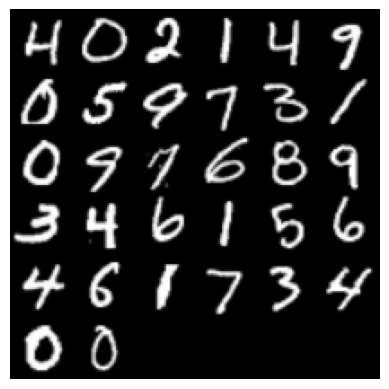

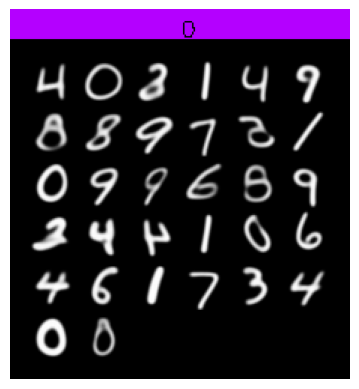

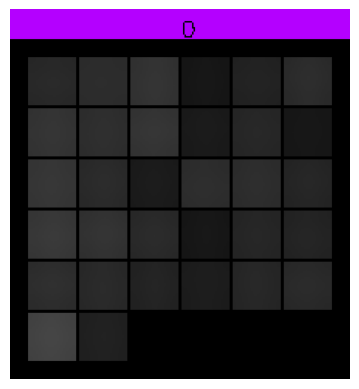

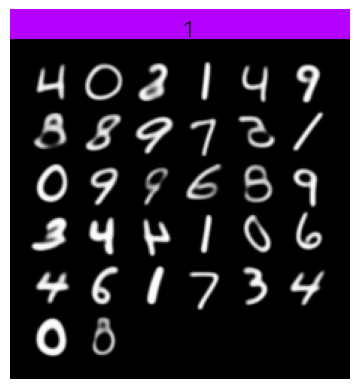

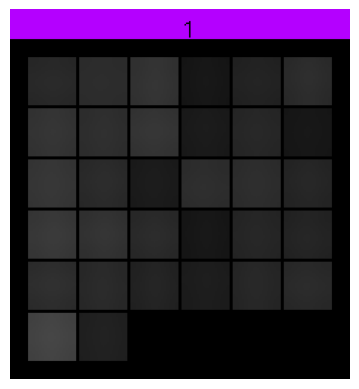

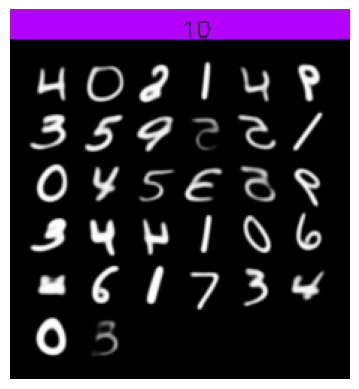

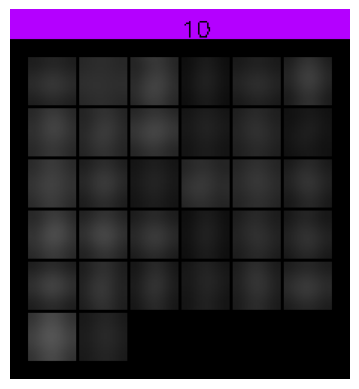

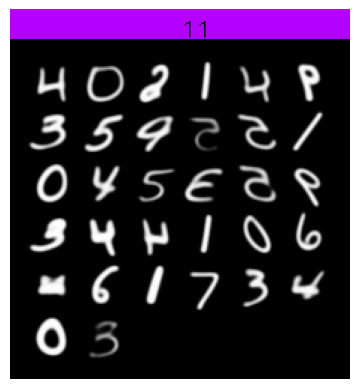

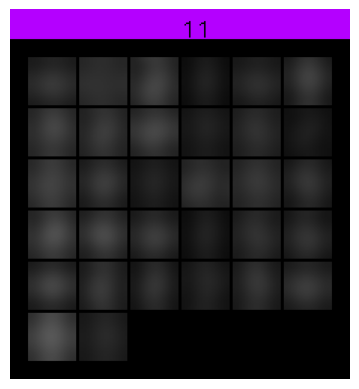

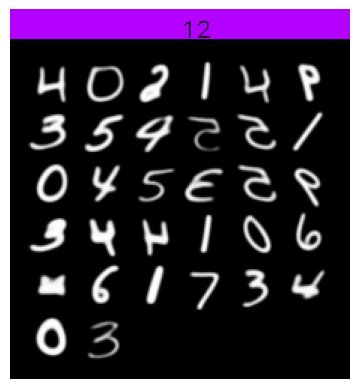

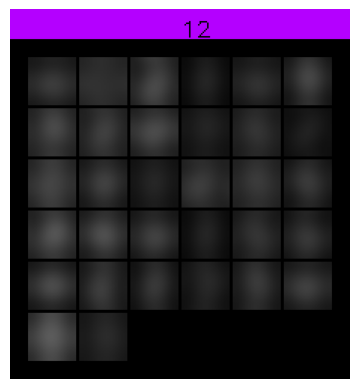

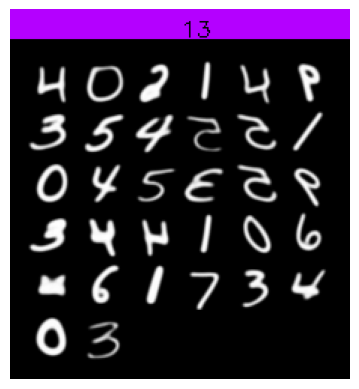

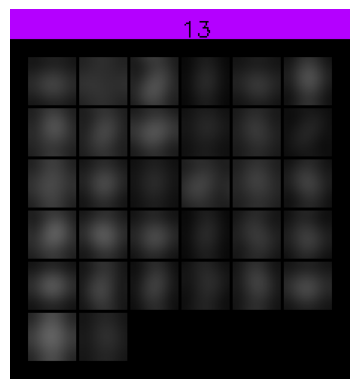

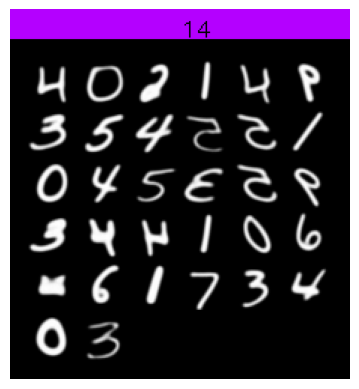

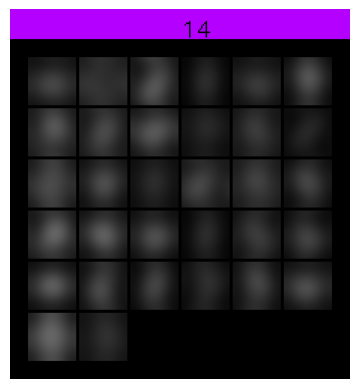

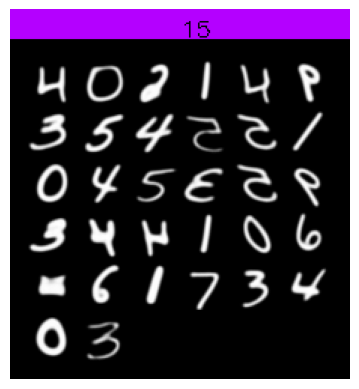

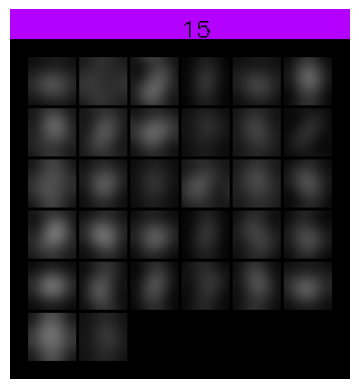

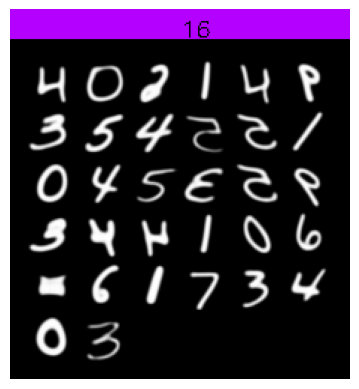

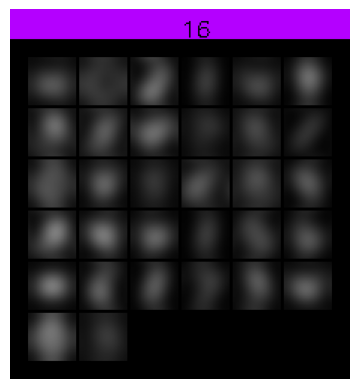

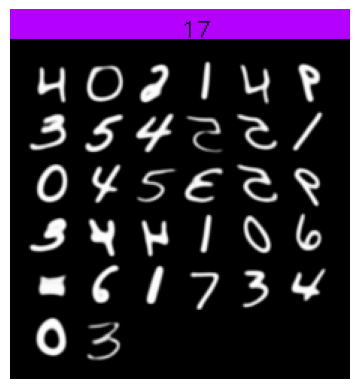

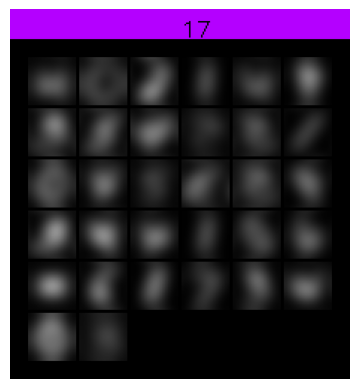

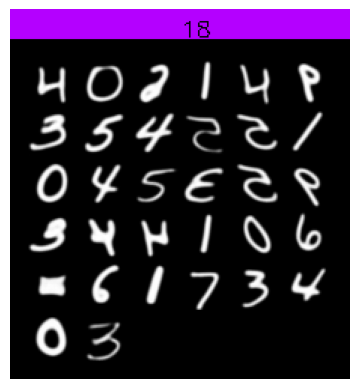

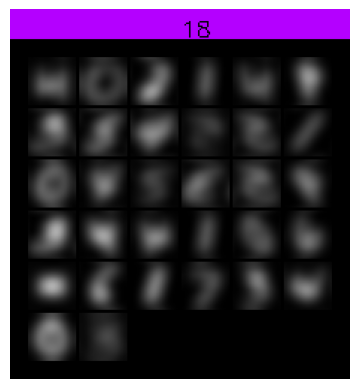

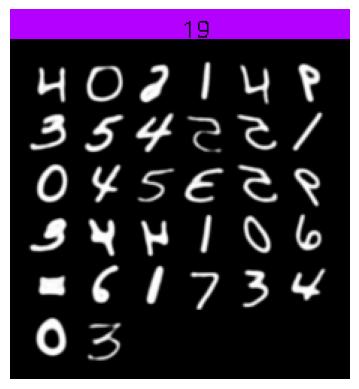

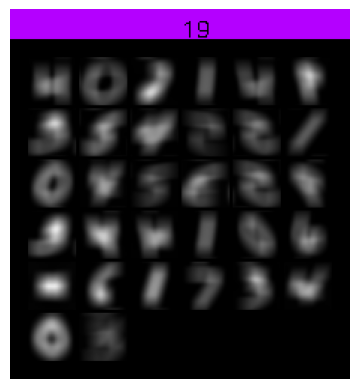

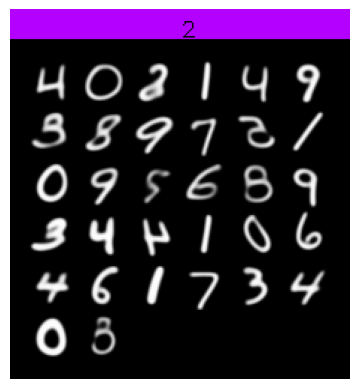

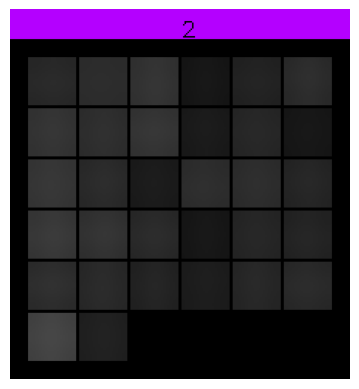

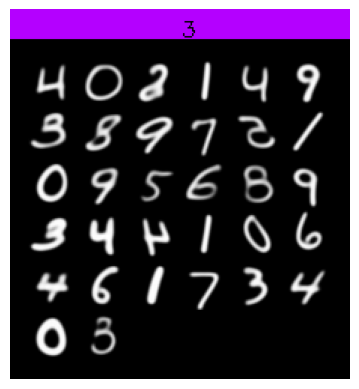

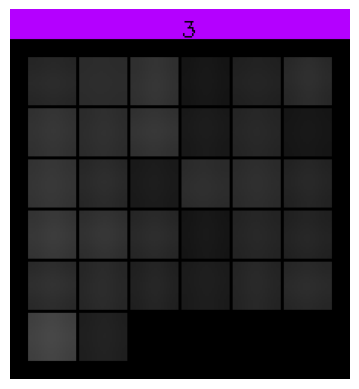

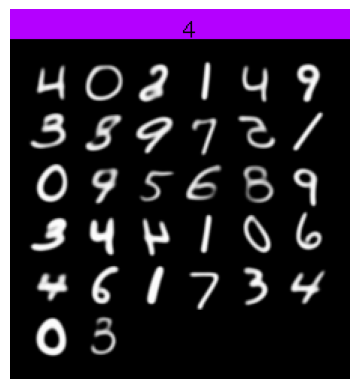

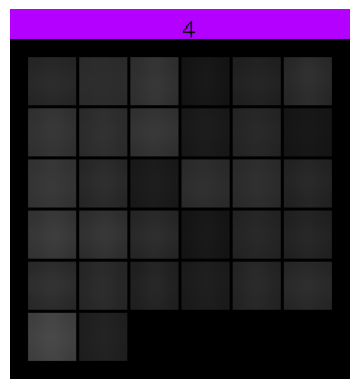

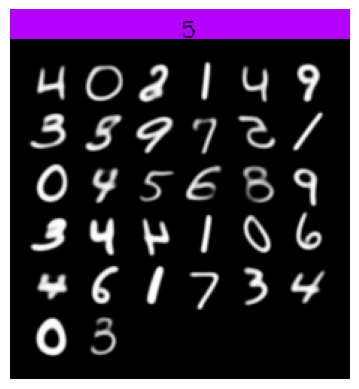

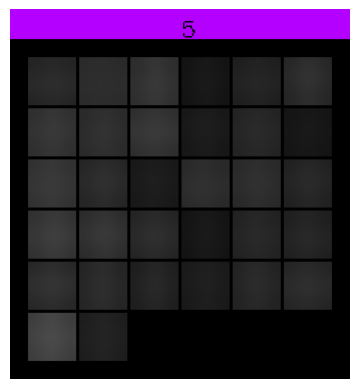

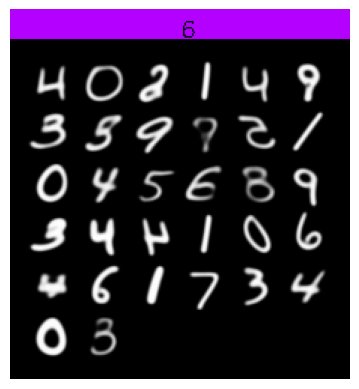

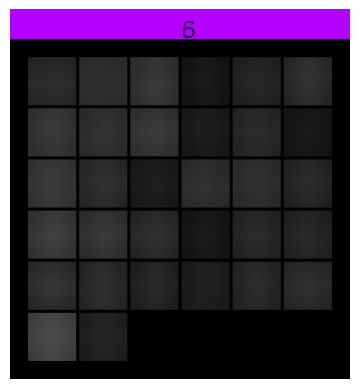

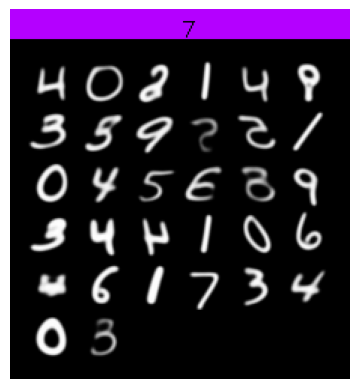

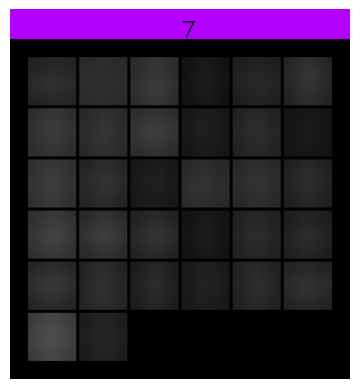

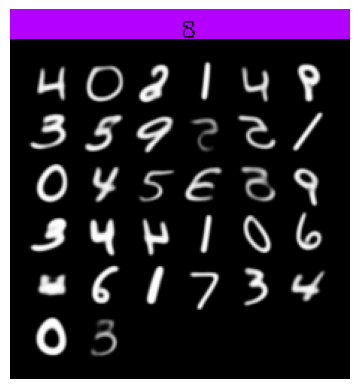

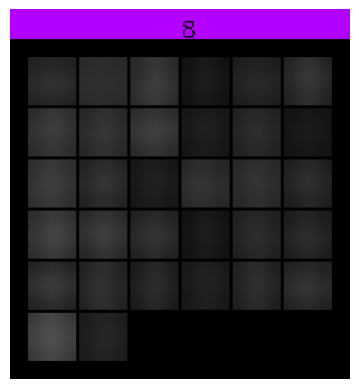

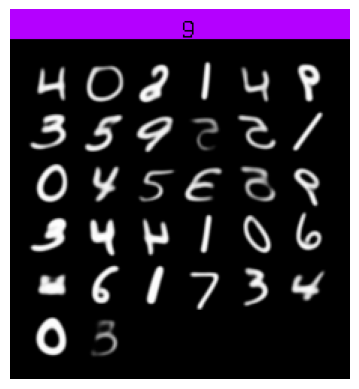

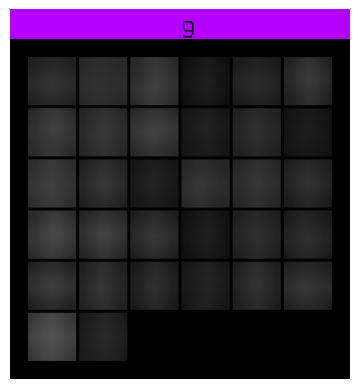

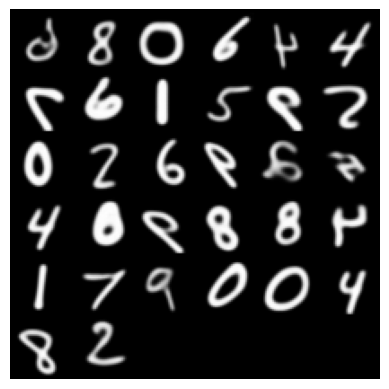

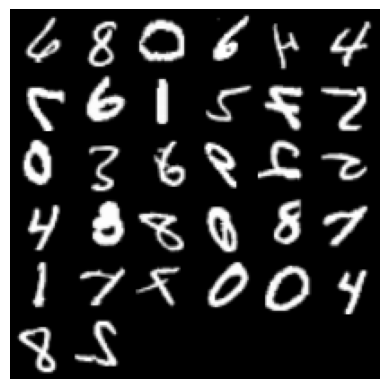

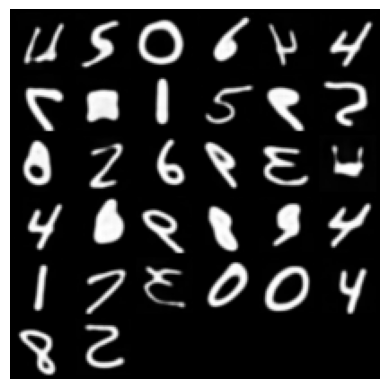

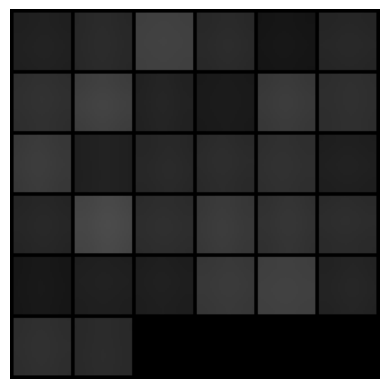

In [36]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the images
path = "/kaggle/working/results_mnist"

# Get a list of all PNG files in the directory and sort them alphabetically
png_files = sorted([f for f in os.listdir(path) if f.endswith('.png')])

# Display each image in alphabetical order
for img_file in png_files:
    img_path = os.path.join(path, img_file)
    img = Image.open(img_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()
